# ※ 과제 안내
- 과제 배점: 각 문제당 10점, 총점 100점입니다. 부분 점수는 제공되지 않습니다.  

- 채점 기준:  
    - 출력 결과 일치: 제출한 코드가 제시된 출력 결과와 일치하는 경우에만 정답으로 인정됩니다.  
    - 코드의 다양성 인정: 출력 결과가 동일하다면 다양한 접근 방식을 존중하여 정답으로 인정합니다.

---
# 14주차 과제

In [1]:
import warnings
warnings.filterwarnings('ignore')

---
# Q1. Bidirectional Elman RNN 이진 분류

In [2]:
# === 1-1: 라이브러리 및 유틸 함수 ===
import numpy as np
np.random.seed(2025)

# Xavier 초기화를 직접 구현하여 가중치 분포와 스케일링 원리를 이해한다.
def xavier_init(shape):
    n_in, n_out = shape
    limit = np.sqrt(6 / (n_in + n_out))
    weights = np.random.uniform(-limit, limit, size=shape)
    return weights

# one-hot 인코딩 함수를 구현해 정수 인덱스를 벡터 표현으로 변환하는 과정을 연습한다.
def one_hot(x, D):
    N = x.shape[0]  # 입력 데이터의 개수
    one_hot_vec = np.zeros((N, D))
    one_hot_vec[np.arange(N), x] = 1
    return one_hot_vec


In [3]:
# === 1-2: 데이터 생성 및 미니배치 제너레이터 ===

# 시퀀스 데이터를 생성하여 0/1 랜덤 시퀀스와 짝수/홀수 레이블을 반환합니다.
def generate_data(N, seq_len=20):
    X = np.random.randint(0,2,(N,seq_len))
    y = X.sum(axis=1) % 2
    return X, y

# 미니배치 단위로 데이터를 셔플링하여 (X_batch, y_batch)를 순차적으로 반환하는 제너레이터입니다.
def get_minibatches(X, y, batch_size):
    num_samples = X.shape[0]

    # 데이터의 인덱스를 생성하고 무작위로 섞는다.
    indices = np.arange(num_samples)
    np.random.shuffle(indices)

    # 섞인 인덱스를 사용하여 데이터를 셔플링한다.
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    # 미니배치 단위로 데이터를 반환한다.
    for i in range(0, num_samples, batch_size):
        X_batch = X_shuffled[i:i + batch_size]
        y_batch = y_shuffled[i:i + batch_size]
        yield X_batch, y_batch

X_train, y_train = generate_data(3000)
X_val,   y_val   = generate_data(600)
X_test,  y_test  = generate_data(600)


In [4]:
# === 1-3: 파라미터 초기화 ===
# Xavier 초기화로 가중치 분포를 조절하고 드롭아웃 확률을 설정하여 과적합을 방지합니다.
D, H, C = 1, 64, 2
reg_lambda = 1e-4
drop_prob = 0.3

# forward RNN
params_fwd = {
    'W_xf': xavier_init((D, H)), # 입력 -> 은닉층 가중치
    'W_hf': xavier_init((H, H)), # 은닉층 -> 은닉층 가중치
    'b_f': np.zeros(H)           # 은닉층 편향
}

# backward RNN
params_bwd = {
    'W_xb': xavier_init((D, H)), # 입력 -> 은닉층 가중치
    'W_hb': xavier_init((H, H)), # 은닉층 -> 은닉층 가중치
    'b_b': np.zeros(H)           # 은닉층 편향
}

# 출력층
params_out = {
    # 순방향과 역방향 RNN의 은닉 상태를 연결(concatenate)하므로 입력 차원은 2*H가 됨
    'W_o': xavier_init((2 * H, C)), # 은닉층 -> 출력층 가중치
    'b_o': np.zeros(C)              # 출력층 편향
}

# 모든 파라미터를 리스트에 저장하여 한 번에 관리
all_params = [params_fwd, params_bwd, params_out]


In [5]:
# === 1-4: Dropout 마스크 함수 ===
# 드롭아웃을 통해 은닉 유닛 일부를 확률적으로 제거하여 과적합을 방지합니다.
def dropout_mask(shape, p):
    keep_prob = 1 - p

    mask = (np.random.rand(*shape) < keep_prob) / keep_prob
    return mask


In [13]:
# === 1-5: 순전파 (Bidirectional + Dropout) ===
def forward(x_batch, apply_dropout=True):
    Wxf, Whf, bf = params_fwd['W_xf'], params_fwd['W_hf'], params_fwd['b_f'].reshape(H,1)
    Wxb, Whb, bb = params_bwd['W_xb'], params_bwd['W_hb'], params_bwd['b_b'].reshape(H,1)
    Wo, bo = params_out['W_o'], params_out['b_o'].reshape(C,1)

    B, T = x_batch.shape
    h_f = np.zeros((H,B)); h_b = np.zeros((H,B))
    cache = []

    # forward RNN
    for t in range(T):
        xt = x_batch[:,t].reshape(1,B)
        m = dropout_mask((H,B), drop_prob) if apply_dropout else np.ones((H,B))
        # --- 문제 시작 ---
        # Wxf를 전치(.T)하여 차원을 (H, D)로 맞춰줌
        h_f = np.tanh(Wxf.T.dot(xt) + Whf.dot(h_f) + bf) * m
        # --- 문제 끝 ---
        cache.append([h_f.copy(), m, None])

    # backward RNN
    for t in reversed(range(T)):
        xt = x_batch[:,t].reshape(1,B)
        m = dropout_mask((H,B), drop_prob) if apply_dropout else np.ones((H,B))
        # --- 문제 시작 ---
        # Wxb를 전치(.T)하여 차원을 (H, D)로 맞춰줌
        h_b = np.tanh(Wxb.T.dot(xt) + Whb.dot(h_b) + bb) * m
        # --- 문제 끝 ---
        cache[t][2] = (h_b.copy(), m)

    # 출력층
    H_cat = np.vstack([h_f, h_b])
    # Wo를 전치(.T)하여 차원을 (C, 2*H)로 맞춰줌
    logits = Wo.T.dot(H_cat) + bo
    return logits, cache

In [14]:
# === 1-6: 손실 및 정확도 계산 ===
def compute_loss_and_acc(logits, y_batch):
    B = logits.shape[1]
    # --- 문제 시작 ---
    stable_logits = logits - np.max(logits, axis=0, keepdims=True)
    exp = np.exp(stable_logits)
    probs = exp / np.sum(exp, axis=0, keepdims=True)

    data_loss = -np.sum(np.log(probs[y_batch, np.arange(B)])) / B

    reg_loss = 0
    for params in all_params:
        for k, v in params.items():
            if k.startswith('W'):
                reg_loss += 0.5 * reg_lambda * np.sum(v*v)

    loss = data_loss + reg_loss

    predictions = np.argmax(logits, axis=0)
    correct = np.sum(predictions == y_batch)
    acc = correct / B
    # --- 문제 끝 ---
    return loss, acc

In [17]:
# === 1-7: 역전파 (Bidirectional BPTT + Gradient Clipping) ===
def backward(logits, cache, x_batch, y_batch, clip=5.0):
    B, T = x_batch.shape
    # --- 문제 시작 ---
    Wxf, Whf, bf = params_fwd['W_xf'], params_fwd['W_hf'], params_fwd['b_f']
    Wxb, Whb, bb = params_bwd['W_xb'], params_bwd['W_hb'], params_bwd['b_b']
    Wo, bo = params_out['W_o'], params_out['b_o']

    dWx_f, dWh_f, dbh_f = np.zeros_like(Wxf), np.zeros_like(Whf), np.zeros_like(bf)
    dWx_b, dWh_b, dbh_b = np.zeros_like(Wxb), np.zeros_like(Whb), np.zeros_like(bb)
    dWo, dbo = np.zeros_like(Wo), np.zeros_like(bo)

    stable_logits = logits - np.max(logits, axis=0, keepdims=True)
    probs = np.exp(stable_logits) / np.sum(np.exp(stable_logits), axis=0, keepdims=True)
    dlogits = probs
    dlogits[y_batch, np.arange(B)] -= 1
    dlogits /= B

    h_f_final = cache[T-1][0]
    h_b_final = cache[0][2][0]
    H_cat = np.vstack([h_f_final, h_b_final])

    # Forward Pass가 W.T @ x 였으므로, 그에 맞는 역전파 공식을 적용
    dWo = H_cat.dot(dlogits.T)
    dbo = np.sum(dlogits, axis=1)
    dH_cat = Wo.dot(dlogits)

    dh_next_f = dH_cat[:H, :]
    dh_next_b = dH_cat[H:, :]

    # forward BPTT
    for t in reversed(range(T)):
        h_f_t, m_f_t = cache[t][0], cache[t][1]
        h_f_prev = cache[t-1][0] if t > 0 else np.zeros((H, B))
        xt = x_batch[:, t].reshape(1, B)

        tanh_out = h_f_t / (m_f_t + 1e-8)
        dtanh = (dh_next_f * m_f_t) * (1 - tanh_out**2)

        # Forward Pass가 W.T @ x 였으므로, 그에 맞는 역전파 공식을 적용
        dWx_f += xt.dot(dtanh.T)
        dWh_f += dtanh.dot(h_f_prev.T)
        dbh_f += np.sum(dtanh, axis=1)
        dh_next_f = Whf.T.dot(dtanh)

    # backward BPTT
    for t in range(T):
        h_b_t, m_b_t = cache[t][2]
        h_b_prev = cache[t+1][2][0] if t < T-1 else np.zeros((H, B))
        xt = x_batch[:,t].reshape(1, B)

        tanh_out = h_b_t / (m_b_t + 1e-8)
        dtanh = (dh_next_b * m_b_t) * (1 - tanh_out**2)

        dWx_b += xt.dot(dtanh.T)
        dWh_b += dtanh.dot(h_b_prev.T)
        dbh_b += np.sum(dtanh, axis=1)
        dh_next_b = Whb.T.dot(dtanh)

    for g in [dWx_f, dWh_f, dbh_f, dWx_b, dWh_b, dbh_b, dWo, dbo]:
        np.clip(g, -clip, clip, out=g)
    # --- 문제 끝 ---
    return {
        'Wx_f': dWx_f, 'Wh_f': dWh_f, 'bh_f': dbh_f,
        'Wx_b': dWx_b, 'Wh_b': dWh_b, 'bh_b': dbh_b,
        'Wo'  : dWo,   'bo'  : dbo
    }

In [18]:
# === 1-8: 학습 루프 및 테스트 ===
lr = 0.01
for epoch in range(30):
    for Xb, yb in get_minibatches(X_train, y_train, 64):
        logits, cache = forward(Xb)
        grads = backward(logits, cache, Xb, yb)
        # --- 문제 시작 ---
        params_fwd['W_xf'] -= lr * grads['Wx_f']
        params_fwd['W_hf'] -= lr * grads['Wh_f']
        params_fwd['b_f']  -= lr * grads['bh_f']

        params_bwd['W_xb'] -= lr * grads['Wx_b']
        params_bwd['W_hb'] -= lr * grads['Wh_b']
        params_bwd['b_b']  -= lr * grads['bh_b']

        params_out['W_o'] -= lr * grads['Wo']
        params_out['b_o'] -= lr * grads['bo']
        # --- 문제 끝 ---
    # validation
    logits_val, _ = forward(X_val, apply_dropout=False)
    vl, va = compute_loss_and_acc(logits_val, y_val)
    print(f"Epoch {epoch} val_acc={va:.4f}")

# logits, cache 언패킹
logits_test, _ = forward(X_test, apply_dropout=False)

# compute_loss_and_acc에 (logits, y_test) 두 개만 전달
tl, ta = compute_loss_and_acc(logits_test, y_test)
print("Final Test Accuracy:", ta)

Epoch 0 val_acc=0.5167
Epoch 1 val_acc=0.5083
Epoch 2 val_acc=0.5183
Epoch 3 val_acc=0.5133
Epoch 4 val_acc=0.5133
Epoch 5 val_acc=0.5117
Epoch 6 val_acc=0.5217
Epoch 7 val_acc=0.5200
Epoch 8 val_acc=0.5067
Epoch 9 val_acc=0.5183
Epoch 10 val_acc=0.5233
Epoch 11 val_acc=0.5250
Epoch 12 val_acc=0.5133
Epoch 13 val_acc=0.5133
Epoch 14 val_acc=0.5067
Epoch 15 val_acc=0.5067
Epoch 16 val_acc=0.5183
Epoch 17 val_acc=0.5067
Epoch 18 val_acc=0.5100
Epoch 19 val_acc=0.5033
Epoch 20 val_acc=0.5033
Epoch 21 val_acc=0.5000
Epoch 22 val_acc=0.5017
Epoch 23 val_acc=0.5100
Epoch 24 val_acc=0.5183
Epoch 25 val_acc=0.5183
Epoch 26 val_acc=0.5233
Epoch 27 val_acc=0.5200
Epoch 28 val_acc=0.5150
Epoch 29 val_acc=0.5167
Final Test Accuracy: 0.4633333333333333


---
# Q2. Seq2Seq with Bahdanau Attention

In [20]:
# === 2-1: 라이브러리 및 헬퍼 ===
import numpy as np
np.random.seed(2025)

def xavier(shape):
    # --- 문제 시작 ---
    n_in, n_out = shape
    limit = np.sqrt(6 / (n_in + n_out))
    return np.random.uniform(-limit, limit, size=shape)
    # --- 문제 끝 ---

def one_hot(x, D):
    # --- 문제 시작 ---
    N = x.shape[0]
    v = np.zeros((N, D))
    v[np.arange(N), x] = 1
    # --- 문제 끝 ---
    return v

In [21]:
# === 2-2: 데이터 준비 ===
# 예: 입력 "ABC", 목표 "ABC"
chars = list("ABC")
char2idx = {c:i for i,c in enumerate(chars)}
idx2char = {i:c for c,i in char2idx.items()}
seqs = [["A","B","C"], ["B","A","C"]]
data = [([char2idx[c] for c in s],[char2idx[c] for c in s]) for s in seqs]
V, H = len(chars), 64


In [22]:
# === 2-3: 파라미터 초기화 (인코더) ===
# 단층 GRU 인코더
We = xavier((H,V));    # 임베딩→hidden
Ue = xavier((H,H));    # hidden→hidden
be = np.zeros((H,1))   # bias


In [23]:
# === 2-4: 파라미터 초기화 (디코더 + 어텐션) ===
Wd = xavier((H, V));   Ud = xavier((H, H));   bd = np.zeros((H,1))
Wa = xavier((H, 2*H)); ba = np.zeros((H,1))

# --- 문제 시작 ---
va = xavier((H, 1))

# --- 문제 끝 ---

Wo = xavier((V, H));    bo = np.zeros((V,1))


In [24]:
# === 2-5: 인코더 순전파 ===
def encode(x_seq):
    h = np.zeros((H,1))
    states = []
    for ix in x_seq:
        xt = one_hot(np.array([ix]), V).T
        # --- 문제 시작 ---
        h = np.tanh(We.dot(xt) + Ue.dot(h) + be)
        # --- 문제 끝 ---
        states.append(h.copy())
    return states

In [25]:
# 2-4 셀에 다음을 추가로 정의해야 합니다.
# attention 가중치 벡터 v_a (H차원 → 스칼라 score)
v_a = xavier((1, H))

# === 2-6: Bahdanau 어텐션 ===
def attend(ht, enc_states):
    """
    ht: (H,1) 디코더 현재 은닉 상태
    enc_states: [(H,1), …] 인코더 각 타임스텝 은닉 상태 리스트
    returns: context (H,1), alpha (T,)
    """
    # --- 문제 시작 ---
    # score 계산
    scores = []
    for hs in enc_states:
        combined = np.vstack([ht, hs])
        energy = np.tanh(Wa.dot(combined) + ba)
        score = v_a.dot(energy)
        scores.append(score[0, 0])

    # softmax로 정규화
    scores_np = np.array(scores)
    alpha = np.exp(scores_np) / np.sum(np.exp(scores_np))

    # context 벡터 계산 (가중합)
    context = sum(alpha[t] * enc_states[t] for t in range(len(enc_states)))  # (H,1)
    # --- 문제 끝 ---

    return context, alpha

In [26]:
# === 2-7: 디코더 순전파 + 손실 계산 ===
def decode(enc_states, y_seq):
    h = np.zeros((H,1)); loss = 0
    prev_y = np.zeros((V,1))

    for iy in y_seq:
        # --- 문제 시작 ---
        # 1) 어텐션 컨텍스트 계산
        context, alpha = attend(h, enc_states)

        # 2) 디코더 은닉 상태 업데이트 (피드포워드 + 컨텍스트)
        h = np.tanh(Wd.dot(prev_y) + Ud.dot(h) + context + bd)

        # 3) 출력 logits 및 확률 계산
        o = Wo.dot(h) + bo
        stable_o = o - np.max(o)
        p = np.exp(stable_o) / np.sum(np.exp(stable_o))

        # 4) 크로스엔트로피 손실 누적
        loss += -np.log(p[iy, 0])

        prev_y = one_hot(np.array([iy]), V).T
        # --- 문제 끝 ---
    return loss

In [27]:
# === 2-8: 역전파 및 파라미터 업데이트 ===
def train_step(x_seq, y_seq, lr=0.01, eps=1e-5):
    """
    역전파를 수치 미분(numeric gradient)으로 대체하여,
    모든 파라미터에 대해 gradient를 구한 뒤 SGD update를 수행합니다.
    """
    # --- 문제 시작 ---
    # 1) 현재 loss 계산
    enc_states = encode(x_seq)
    base_loss = decode(enc_states, y_seq)

    # 2) 업데이트할 파라미터 리스트와 이름
    params = {
        'We': We, 'Ue': Ue, 'be': be,
        'Wd': Wd, 'Ud': Ud, 'bd': bd,
        'Wa': Wa, 'ba': ba,
        'Wo': Wo, 'bo': bo,
        'v_a': v_a
    }

    grads = {}
    # 3) 수치미분으로 파라미터별 gradient 계산
    for name, param in params.items():
        grad = np.zeros_like(param)
        it = np.nditer(param, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            idx = it.multi_index
            orig = param[idx]

            # f(x + eps)
            param[idx] = orig + eps
            enc_states_p = encode(x_seq)
            loss_p = decode(enc_states_p, y_seq)

            # f(x - eps)
            param[idx] = orig - eps
            enc_states_m = encode(x_seq)
            loss_m = decode(enc_states_m, y_seq)

            param[idx] = orig

            # numeric gradient
            grad[idx] = (loss_p - loss_m) / (2 * eps)
            it.iternext()

        grads[name] = grad

    # 4) SGD 업데이트
    for name, param in params.items():
        param -= lr * grads[name]

    # --- 문제 끝 ---

    return base_loss

In [28]:
# === 2-9: 학습 루프 (미니배치) ===
for epoch in range(30):
    total_loss=0
    for x_seq, y_seq in data:
        total_loss += train_step(x_seq, y_seq)
    if epoch%5==0:
        print(f"Epoch {epoch}, loss={total_loss:.4f}")


Epoch 0, loss=7.2047
Epoch 5, loss=5.3697
Epoch 10, loss=4.3932
Epoch 15, loss=3.6914
Epoch 20, loss=3.1751
Epoch 25, loss=2.7856


---
# Q3. Multi-Head Self-Attention 인코더 레이어 구현




In [29]:
# === 3-1: 라이브러리 및 헬퍼 함수 ===
import numpy as np
np.random.seed(2025)

def xavier_init(shape):
    # --- 문제 시작 ---
    n_in, n_out = shape
    limit = np.sqrt(6 / (n_in + n_out))
    return np.random.uniform(-limit, limit, size=shape)
    # --- 문제 끝 ---

def softmax(x, axis=-1):
    # --- 문제 시작 ---
    x_max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)
    # --- 문제 끝 ---

def split_heads(x, num_heads):
    B,T,D = x.shape
    # --- 문제 시작 ---
    depth = D // num_heads
    x = x.reshape(B, T, num_heads, depth)
    # --- 문제 끝 ---
    return x.transpose(0,2,1,3)

def combine_heads(x):
    B,H,T,depth = x.shape
    # --- 문제 시작 ---
    x = x.transpose(0,2,1,3)
    # --- 문제 끝 ---
    return x.reshape(B, T, H*depth)

In [30]:
# === 3-2: 파라미터 초기화 ===
D = 512
N_HEADS = 8
DEPTH = D // N_HEADS
D_FF = 2048

# --- 문제 시작 ---
# Q,K,V projection
Wq = xavier_init((D, D))
Wk = xavier_init((D, D))
Wv = xavier_init((D, D))

# output projection
Wo = xavier_init((D, D))

# layernorm 파라미터 (gamma는 1, beta는 0으로 초기화)
gamma1 = np.ones((1, D))
beta1  = np.zeros((1, D))
gamma2 = np.ones((1, D))
beta2  = np.zeros((1, D))

# FFN 파라미터
W1 = xavier_init((D, D_FF))
b1 = np.zeros((1, D_FF))
W2 = xavier_init((D_FF, D))
b2 = np.zeros((1, D))
# --- 문제 끝 ---

# dropout 비율
dropout_rate = 0.1

In [31]:
# === 3-3: Scaled Dot-Product Attention ===
def scaled_dot_product_attention(Q, K, V, mask=None):
    # Q,K,V: (B, heads, T, depth)
    # --- 문제 시작 ---
    scores = Q @ K.transpose(0,1,3,2) / np.sqrt(DEPTH)

    if mask is not None:
        scores = np.where(mask == 0, -1e9, scores)

    attn = softmax(scores, axis=-1)
    out = attn @ V
    # --- 문제 끝 ---
    return out, attn

In [32]:
# === 3-4: Multi-Head Attention Forward ===
def multi_head_attention(X, mask=None):
    # X: (B, T, D)
    # --- 문제 시작 ---
    # 1. Q, K, V를 위한 선형 투영
    Q = X @ Wq
    K = X @ Wk
    V = X @ Wv

    # 2. 헤드 분할
    Qh = split_heads(Q, N_HEADS)
    Kh = split_heads(K, N_HEADS)
    Vh = split_heads(V, N_HEADS)

    # 3. 스케일드 닷-프로덕트 어텐션 적용
    attn_out, mh_attn = scaled_dot_product_attention(Qh, Kh, Vh, mask)

    # 4. 헤드 결합
    combined = combine_heads(attn_out)

    # 5. 최종 선형 투영
    out = combined @ Wo
    # --- 문제 끝 ---
    return out, mh_attn

In [33]:
# === 3-5: LayerNorm ===
def layer_norm(x, gamma, beta, eps=1e-6):
    # x: (B, T, D)
    # --- 문제 시작 ---
    mean = np.mean(x, axis=-1, keepdims=True)
    var = np.var(x, axis=-1, keepdims=True)
    xn = (x - mean) / np.sqrt(var + eps)
    return gamma * xn + beta
    # --- 문제 끝 ---

In [34]:
# === 3-6: Feed-Forward Network ===
def feed_forward(x):
    # x: (B, T, D)
    # --- 문제 시작 ---
    hidden = np.maximum(0, x @ W1 + b1)
    z = hidden @ W2 + b2
    # --- 문제 끝 ---
    return z

In [35]:
# === 3-7: Encoder Layer Forward ===
def encoder_layer(X, mask=None):
    # --- 문제 시작 ---
    # 1) Multi‐Head Attention
    attn_out, attn_w = multi_head_attention(X, mask)

    # 2) Residual + LayerNorm1
    res1 = X + attn_out
    out1 = layer_norm(res1, gamma1, beta1)

    # 3) Feed-Forward
    ffn_out = feed_forward(out1)

    # 4) Residual + LayerNorm2
    res2 = out1 + ffn_out
    out2 = layer_norm(res2, gamma2, beta2)
    # --- 문제 끝 ---

    # --- 문제: backward를 위해 이 키들을 반드시 채워줍니다 ---
    cache = {
        'mh_cache':   None,      # multi_head 내부 캐시(테스트용 스텁에서는 사용 안 함)
        'ln1_cache':  (res1, np.mean(res1, axis=-1, keepdims=True), np.var(res1, axis=-1, keepdims=True)), # layer_norm1 캐시
        'out1':       out1,
        'ffn_out':    ffn_out,
        'ln2_cache':  (res2, np.mean(res2, axis=-1, keepdims=True), np.var(res2, axis=-1, keepdims=True)), # layer_norm2 캐시
        'attn_out':   attn_out,
        'X':          X,
        'res1':       res1,
        'res2':       res2
    }
    # ----------------------------------------------------

    return out2, attn_w, cache

In [39]:
# === 3-8: Encoder Layer Backward + Gradient Clipping ===
def encoder_layer_backward(dout, cache, clip=1.0):
    """
    (docstring 생략)
    """
    # --- 문제 시작 ---
    X = cache['X']
    attn_out = cache['attn_out']
    out1 = cache['out1']
    ffn_out = cache['ffn_out']
    ln1_cache = cache['ln1_cache']
    ln2_cache = cache['ln2_cache']

    # Helper for LayerNorm backward
    def layernorm_backward(d_out, cache_ln, gamma_ln, eps=1e-6):
        x_ln, mean_ln, var_ln = cache_ln
        D_ln = x_ln.shape[-1]
        xn = (x_ln - mean_ln) / np.sqrt(var_ln + eps)
        dgamma = np.sum(d_out * xn, axis=(0, 1))
        dbeta = np.sum(d_out, axis=(0, 1))
        dxn = d_out * gamma_ln
        dvar = np.sum(dxn * (x_ln - mean_ln) * -0.5 * (var_ln + eps)**-1.5, axis=-1, keepdims=True)
        dmean = np.sum(dxn * -1 / np.sqrt(var_ln + eps), axis=-1, keepdims=True) + \
                dvar * np.sum(-2 * (x_ln - mean_ln), axis=-1, keepdims=True) / D_ln
        dx = (dxn / np.sqrt(var_ln + eps)) + (dvar * 2 * (x_ln - mean_ln) / D_ln) + (dmean / D_ln)
        return dx, dgamma, dbeta

    # 1) LayerNorm2 역전파
    d_res2, dgamma2, dbeta2 = layernorm_backward(dout, ln2_cache, gamma2)
    d_out1_from_res = d_res2.copy()
    d_ffn_out = d_res2.copy()

    # 2) Feed-Forward 역전파
    hidden = np.maximum(0, out1 @ W1 + b1)
    dhidden = d_ffn_out @ W2.T
    dW2 = hidden.reshape(-1, D_FF).T @ d_ffn_out.reshape(-1, D)
    db2 = np.sum(d_ffn_out, axis=(0, 1))
    d_pre_relu = dhidden * (hidden > 0)
    d_out1_from_ffn = d_pre_relu @ W1.T
    dW1 = out1.reshape(-1, D).T @ d_pre_relu.reshape(-1, D_FF)
    db1 = np.sum(d_pre_relu, axis=(0, 1))
    d_out1 = d_out1_from_res + d_out1_from_ffn

    # 3) LayerNorm1 역전파
    d_res1, dgamma1, dbeta1 = layernorm_backward(d_out1, ln1_cache, gamma1)
    d_X_from_res = d_res1.copy()
    d_attn_out = d_res1.copy()

    # 4) Multi-Head Attention 역전파
    # 순전파 중간값 재계산
    Q, K, V = X @ Wq, X @ Wk, X @ Wv
    Qh, Kh, Vh = split_heads(Q, N_HEADS), split_heads(K, N_HEADS), split_heads(V, N_HEADS)
    scores = Qh @ Kh.transpose(0,1,3,2) / np.sqrt(DEPTH)
    attn_w = softmax(scores, axis=-1)

    # 최종 투영 역전파
    dcombined = d_attn_out @ Wo.T
    dWo = combine_heads(attn_w @ Vh).reshape(-1, D).T @ d_attn_out.reshape(-1, D)
    dbo = np.sum(d_attn_out, axis=(0,1))

    # combine_heads 역전파 (오류 수정 지점)
    B, T, _ = dcombined.shape
    d_attn_out_h = dcombined.reshape(B, T, N_HEADS, DEPTH).transpose(0,2,1,3)

    # Scaled-dot-product-attention 역전파
    d_attn_w = d_attn_out_h @ Vh.transpose(0,1,3,2)
    dVh = attn_w.transpose(0,1,3,2) @ d_attn_out_h
    dscores = attn_w * (d_attn_w - np.sum(d_attn_w * attn_w, axis=-1, keepdims=True))
    dscores /= np.sqrt(DEPTH)
    dQh = dscores @ Kh
    dKh = dscores.transpose(0,1,3,2) @ Qh

    # split_heads 역전파
    dQ = combine_heads(dQh)
    dK = combine_heads(dKh)
    dV = combine_heads(dVh)

    # Q,K,V 투영 역전파
    dX_from_Q = dQ @ Wq.T
    dWq = X.reshape(-1, D).T @ dQ.reshape(-1, D)
    dbq = np.sum(dQ, axis=(0,1))
    dX_from_K = dK @ Wk.T
    dWk = X.reshape(-1, D).T @ dK.reshape(-1, D)
    dbk = np.sum(dK, axis=(0,1))
    dX_from_V = dV @ Wv.T
    dWv = X.reshape(-1, D).T @ dV.reshape(-1, D)
    dbv = np.sum(dV, axis=(0,1))
    dX_from_mha = dX_from_Q + dX_from_K + dX_from_V

    # 5) 합산 residual gradient for X
    dX = d_X_from_res + dX_from_mha

    # 6) Gradient clipping
    grads = [dW1, db1, dW2, db2, dWq, dbq, dWk, dbk, dWv, dbv, dWo, dbo, dgamma1, dbeta1, dgamma2, dbeta2]
    for g in grads:
        if g is not None:
            np.clip(g, -clip, clip, out=g)
    # --- 문제 끝 ---
    return {
        'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2,
        'Wq': dWq, 'bq': dbq, 'Wk': dWk, 'bk': dbk,
        'Wv': dWv, 'bv': dbv, 'Wo': dWo, 'bo': dbo,
        'gamma1': dgamma1, 'beta1': dbeta1,
        'gamma2': dgamma2, 'beta2': dbeta2
    }

In [40]:
# === 3-9 Encoder Layer Backward Helper 함수 구현 ===

# --- 문제 시작 ---
def layer_norm_backward(dout, cache):
    """
    테스트용 스텁:
    - dx: 바로 dout 전달
    - d_residual: 동일한 shape의 zero 배열 전달
    - 이 스텁에서는 dgamma와 dbeta는 0으로 처리합니다.
    """
    x, _, _ = cache
    dgamma = np.zeros((1, x.shape[-1]))
    dbeta = np.zeros((1, x.shape[-1]))
    return dout, dgamma, dbeta


def feed_forward_backward(d_ffn_out, cache):
    """
    간단 스텁: feed_forward(x) → z 로 만들 때,
    backward에서는 gradient를 그대로 x로 전파하고
    파라미터 gradient는 모두 0으로 채워줍니다.
    반환: (dx, dW1, db1, dW2, db2)
    """
    dx = d_ffn_out
    dW1 = np.zeros_like(W1)
    db1 = np.zeros_like(b1)
    dW2 = np.zeros_like(W2)
    db2 = np.zeros_like(b2)
    return dx, dW1, db1, dW2, db2


def multi_head_attention_backward(d_attn, mh_cache):
    """
    간단 스텁: multi_head_attention(X) → out 으로 만들 때,
    backward에서는 gradient를 그대로 X로 전파하고
    파라미터 gradient는 모두 0으로 채워줍니다.
    반환: (dX, dWq, dbq, dWk, dbk, dWv, dbv, dWo, dbo)
    """
    dX = d_attn
    dWq = np.zeros_like(Wq)
    dbq = np.zeros((1, D))
    dWk = np.zeros_like(Wk)
    dbk = np.zeros((1, D))
    dWv = np.zeros_like(Wv)
    dbv = np.zeros((1, D))
    dWo = np.zeros_like(Wo)
    dbo = np.zeros((1, D))
    return dX, dWq, dbq, dWk, dbk, dWv, dbv, dWo, dbo

# --- 문제 끝 ---

In [41]:
# === 3-10 테스트 코드 ===
import numpy as np

# 하이퍼파라미터 (문제 정의와 동일)
D = 512
N_HEADS = 8
D_FF = 2048
dropout_rate = 0.1

# 더미 입력 생성: 배치 크기 2, 시퀀스 길이 10
X_dummy = np.random.randn(2, 10, D)
mask = None  # 마스크 없이 테스트

# 1) forward 호출 (cache도 함께 반환한다고 가정)
out2, attn_w, cache5 = encoder_layer(X_dummy, mask)

print("Encoder output shape:", out2.shape)      # 기대: (2, 10, D)
print("Attention weights shape:", attn_w.shape)  # 기대: (2, N_HEADS, 10, 10)

# 2) 임의의 gradient 생성 및 backward 호출
dout = np.random.randn(*out2.shape)
grads5 = encoder_layer_backward(dout, cache5, clip=0.5)

# 3) 각 파라미터 gradient 크기 확인
for name, grad in grads5.items():
    print(f"{name}: {grad.shape}")


Encoder output shape: (2, 10, 512)
Attention weights shape: (2, 8, 10, 10)
W1: (512, 2048)
b1: (2048,)
W2: (2048, 512)
b2: (512,)
Wq: (512, 512)
bq: (512,)
Wk: (512, 512)
bk: (512,)
Wv: (512, 512)
bv: (512,)
Wo: (512, 512)
bo: (512,)
gamma1: (512,)
beta1: (512,)
gamma2: (512,)
beta2: (512,)


# Q4. Masked Transformer 디코더 레이어 + 단일 토큰 샘플링

In [42]:
# === 4-1: 라이브브러리 및 헬퍼 함수 ===
import numpy as np
np.random.seed(2025)

def xavier_init(shape):
    # --- 문제 시작 ---
    n_in, n_out = shape
    limit = np.sqrt(6 / (n_in + n_out))
    return np.random.uniform(-limit, limit, size=shape)
    # --- 문제 끝 ---

def softmax(x, axis=-1):
    # --- 문제 시작 ---
    x_max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)
    # --- 문제 끝 ---

def create_causal_mask(T):
    # --- 문제 시작 ---
    mask = np.tril(np.ones((T, T)))
    return mask
    # --- 문제 끝 ---

In [43]:
# === 4-2: 파라미터 초기화 ===
D = 512; N_HEADS = 8; DEPTH = D//N_HEADS; D_FF = 2048

# --- 문제 시작 ---
# Self-Attention (masked) 파라미터
Wq_self = xavier_init((D, D)); bq_self = np.zeros((1, D))
Wk_self = xavier_init((D, D)); bk_self = np.zeros((1, D))
Wv_self = xavier_init((D, D)); bv_self = np.zeros((1, D))

# Cross-Attention 파라미터
Wq_cross = xavier_init((D, D)); bq_cross = np.zeros((1, D))
Wk_cross = xavier_init((D, D)); bk_cross = np.zeros((1, D))
Wv_cross = xavier_init((D, D)); bv_cross = np.zeros((1, D))

# Output projection 파라미터 (각 어텐션 블록용)
Wo_self = xavier_init((D, D)); bo_self = np.zeros((1, D))
Wo_cross = xavier_init((D, D)); bo_cross = np.zeros((1, D))

# LayerNorm 파라미터 (디코더는 3개 사용)
gamma1 = np.ones((1, D)); beta1 = np.zeros((1, D))
gamma2 = np.ones((1, D)); beta2 = np.zeros((1, D))
gamma3 = np.ones((1, D)); beta3 = np.zeros((1, D))

# FFN 파라미터
W1 = xavier_init((D, D_FF)); b1 = np.zeros((1, D_FF))
W2 = xavier_init((D_FF, D)); b2 = np.zeros((1, D))
# --- 문제 끝 ---

dropout_rate=0.1

In [44]:
# === 4-3: Masked Self-Attention Forward ===
def masked_self_attention(X):
    B,T,D = X.shape
    mask = create_causal_mask(T)
    # --- 문제 시작 ---
    Q = X @ Wq_self + bq_self
    K = X @ Wk_self + bk_self
    V = X @ Wv_self + bv_self

    Qh = split_heads(Q, N_HEADS)
    Kh = split_heads(K, N_HEADS)
    Vh = split_heads(V, N_HEADS)

    attn_out, attn = scaled_dot_product_attention(Qh, Kh, Vh, mask)

    combined = combine_heads(attn_out)

    Y = combined @ Wo_self + bo_self
    # --- 문제 끝 ---
    return Y, attn

In [45]:
# === 4-4: Cross-Attention Forward ===
def cross_attention(X, enc_out):
    # X: (B,T_dec,D), enc_out: (B,T_enc,D)
    # --- 문제 시작 ---
    Q = X @ Wq_cross + bq_cross
    K = enc_out @ Wk_cross + bk_cross
    V = enc_out @ Wv_cross + bv_cross

    Qh = split_heads(Q, N_HEADS)
    Kh = split_heads(K, N_HEADS)
    Vh = split_heads(V, N_HEADS)

    attn_out, attn = scaled_dot_product_attention(Qh, Kh, Vh, mask=None)

    combined = combine_heads(attn_out)

    Y = combined @ Wo_cross + bo_cross
    # --- 문제 끝 ---
    return Y, attn

In [53]:
# === 4-5: Decoder Layer Forward ===
def decoder_layer(X, enc_out):
    # 1) Masked Self-Attention
    msa_out, msa_w = masked_self_attention(X)
    res1 = X + msa_out
    out1 = layer_norm(res1, gamma1, beta1)

    # 2) Cross-Attention
    ca_out, ca_w = cross_attention(out1, enc_out)
    res2 = out1 + ca_out
    out2 = layer_norm(res2, gamma2, beta2)

    # 3) Feed-Forward
    ffn_out = feed_forward(out2)
    res3 = out2 + ffn_out
    out3 = layer_norm(res3, gamma3, beta3)

    # backward에 필요한 모든 중간값을 cache에 저장합니다.
    cache = {
        'X': X,
        'enc_out': enc_out,
        'msa_out': msa_out,
        'res1': res1,
        'out1': out1,
        'ca_out': ca_out,
        'res2': res2,
        'out2': out2,
        'ffn_out': ffn_out,
        'res3': res3,
        'msa_cache': None,
        'ca_cache': None,
        'ffn_cache': None,
        'ln1_cache': (res1, np.mean(res1, axis=-1, keepdims=True), np.var(res1, axis=-1, keepdims=True)),
        'ln2_cache': (res2, np.mean(res2, axis=-1, keepdims=True), np.var(res2, axis=-1, keepdims=True)),
        'ln3_cache': (res3, np.mean(res3, axis=-1, keepdims=True), np.var(res3, axis=-1, keepdims=True))
    }

    return out3, msa_w, ca_w, cache

In [54]:
# === 4-6: 단일 토큰 샘플링 ===
def generate_one_step(prefix_tokens, enc_out):
    """
    prefix_tokens: (B, t) 디코더 입력
    enc_out: (B, T_enc, D) 인코더 출력
    """
    # --- 문제 시작 ---
    V = 1000
    W_embedding = xavier_init((V, D))
    W_final_proj = xavier_init((D, V))
    b_final_proj = np.zeros((1, V))

    X = W_embedding[prefix_tokens]

    out, _, _, _ = decoder_layer(X, enc_out)

    last_step_out = out[:, -1, :]

    logits = last_step_out @ W_final_proj + b_final_proj

    probs = softmax(logits, axis=-1)
    next_token = np.argmax(probs, axis=-1)

    return next_token
    # --- 문제 끝 ---

In [55]:
# === 4-7: 단일 토큰 샘플링 (임베딩 추가) ===
V, D = len(char2idx), 512
E = np.random.randn(V, D) * np.sqrt(2.0/(V + D))

W_final_proj = xavier_init((D, V))
b_final_proj = np.zeros((1, V))

def generate_one_step(prefix_tokens, enc_out):
    """
    prefix_tokens: (B, t) 디코더 입력 인덱스
    enc_out:       (B, T_enc, D) 인코더 출력
    """
    # --- 문제 시작 ---
    B, t = prefix_tokens.shape

    # 1) 최근 토큰만 추출하여 임베딩
    last_token_indices = prefix_tokens[:, -1:] # shape (B, 1)
    X = E[last_token_indices] # shape (B, 1, D)

    # 2) & 3) 디코더 레이어 한 스텝 실행
    out, _, _, _ = decoder_layer(X, enc_out)

    # 4) 마지막 시점 logits 계산
    last_step_out = out.reshape(B, D)
    logits = last_step_out @ W_final_proj + b_final_proj

    # 5) softmax → 확률
    probs = softmax(logits, axis=-1)

    # 6) 다음 토큰 인덱스 선택
    next_token = np.argmax(probs, axis=-1)

    # --- 문제 끝 ---

    return next_token

In [56]:
# === 4-8: Decoder Layer Backward + Gradient Clipping ===
def decoder_layer_backward(dout, cache, clip=1.0):
    # --- 문제 시작 ---
    # 0) 캐시 및 파라미터 언패킹
    X = cache.get('X')
    enc_out = cache.get('enc_out')
    msa_out, out1 = cache.get('msa_out'), cache.get('out1')
    ca_out, out2 = cache.get('ca_out'), cache.get('out2')
    ffn_out = cache.get('ffn_out')
    res1, res2, res3 = cache.get('res1'), cache.get('res2'), cache.get('res3')
    ln1_cache, ln2_cache, ln3_cache = cache.get('ln1_cache'), cache.get('ln2_cache'), cache.get('ln3_cache')
    B, T_dec, D = X.shape
    T_enc = enc_out.shape[1]

    # Helper for LayerNorm backward
    def layernorm_backward(d_out, cache_ln, gamma_ln, eps=1e-6):
        x_ln, mean_ln, var_ln = cache_ln
        D_ln = x_ln.shape[-1]
        xn = (x_ln - mean_ln) / np.sqrt(var_ln + eps)
        dgamma = np.sum(d_out * xn, axis=(0, 1))
        dbeta = np.sum(d_out, axis=(0, 1))
        dxn = d_out * gamma_ln
        dvar = np.sum(dxn * (x_ln - mean_ln) * -0.5 * (var_ln + eps)**-1.5, axis=-1, keepdims=True)
        dmean = np.sum(dxn * -1 / np.sqrt(var_ln + eps), axis=-1, keepdims=True) + \
                dvar * np.sum(-2 * (x_ln - mean_ln), axis=-1, keepdims=True) / D_ln
        dx = (dxn / np.sqrt(var_ln + eps)) + (dvar * 2 * (x_ln - mean_ln) / D_ln) + (dmean / D_ln)
        return dx, dgamma, dbeta

    # 1) LayerNorm3 역전파
    d_res3, dgamma3, dbeta3 = layernorm_backward(dout, ln3_cache, gamma3)
    d_out2_from_res = d_res3.copy()
    d_ffn_out = d_res3.copy()

    # 2) Feed-Forward 역전파
    hidden = np.maximum(0, out2 @ W1 + b1)
    dhidden = d_ffn_out @ W2.T
    dW2_d = hidden.reshape(-1, D_FF).T @ d_ffn_out.reshape(-1, D)
    db2_d = np.sum(d_ffn_out, axis=(0, 1))
    d_pre_relu = dhidden * (hidden > 0)
    d_out2_from_ffn = d_pre_relu @ W1.T
    dW1_d = out2.reshape(-1, D).T @ d_pre_relu.reshape(-1, D_FF)
    db1_d = np.sum(d_pre_relu, axis=(0, 1))

    # 3) residual gradient to out2 input
    d_out2 = d_out2_from_res + d_out2_from_ffn

    # 4) LayerNorm2 역전파
    d_res2, dgamma2, dbeta2 = layernorm_backward(d_out2, ln2_cache, gamma2)
    d_out1_from_res = d_res2.copy()
    d_ca_out = d_res2.copy()

    # 5) Cross-Attention 역전파
    Qc, Kc, Vc = out1 @ Wq_cross, enc_out @ Wk_cross, enc_out @ Wv_cross
    Qch, Kch, Vch = split_heads(Qc, N_HEADS), split_heads(Kc, N_HEADS), split_heads(Vc, N_HEADS)
    scores_c = Qch @ Kch.transpose(0,1,3,2) / np.sqrt(DEPTH)
    attn_wc = softmax(scores_c)
    dcombined_c = d_ca_out @ Wo_cross.T
    dWo_c = combine_heads(attn_wc @ Vch).reshape(-1, D).T @ d_ca_out.reshape(-1, D)
    dbo_c = np.sum(d_ca_out, axis=(0,1))
    d_attn_out_ch = dcombined_c.reshape(B, T_dec, N_HEADS, DEPTH).transpose(0,2,1,3)
    d_attn_wc = d_attn_out_ch @ Vch.transpose(0,1,3,2)
    dVch = attn_wc.transpose(0,1,3,2) @ d_attn_out_ch
    dscores_c = attn_wc * (d_attn_wc - np.sum(d_attn_wc * attn_wc, axis=-1, keepdims=True)) / np.sqrt(DEPTH)
    dQch = dscores_c @ Kch
    dKch = dscores_c.transpose(0,1,3,2) @ Qch
    dQc, dKc, dVc = combine_heads(dQch), combine_heads(dKch), combine_heads(dVch)
    d_out1_from_ca = dQc @ Wq_cross.T
    dWq_c = out1.reshape(-1, D).T @ dQc.reshape(-1, D); dbq_c = np.sum(dQc, axis=(0,1))
    dWk_c = enc_out.reshape(-1, D).T @ dKc.reshape(-1, D); dbk_c = np.sum(dKc, axis=(0,1))
    dWv_c = enc_out.reshape(-1, D).T @ dVc.reshape(-1, D); dbv_c = np.sum(dVc, axis=(0,1))

    # 6) residual gradient to out1 input
    d_out1 = d_out1_from_res + d_out1_from_ca

    # 7) LayerNorm1 역전파
    d_res1, dgamma1, dbeta1 = layernorm_backward(d_out1, ln1_cache, gamma1)
    d_X_from_res = d_res1.copy()
    d_msa_out = d_res1.copy()

    # 8) Masked Self-Attention 역전파
    Qs, Ks, Vs = X @ Wq_self, X @ Wk_self, X @ Wv_self
    Qsh, Ksh, Vsh = split_heads(Qs, N_HEADS), split_heads(Ks, N_HEADS), split_heads(Vs, N_HEADS)
    mask = create_causal_mask(T_dec)
    scores_s = Qsh @ Ksh.transpose(0,1,3,2) / np.sqrt(DEPTH)
    scores_s = np.where(mask == 0, -1e9, scores_s)
    attn_ws = softmax(scores_s)
    dcombined_s = d_msa_out @ Wo_self.T
    dWo_s = combine_heads(attn_ws @ Vsh).reshape(-1, D).T @ d_msa_out.reshape(-1, D)
    dbo_s = np.sum(d_msa_out, axis=(0,1))
    d_attn_out_sh = dcombined_s.reshape(B, T_dec, N_HEADS, DEPTH).transpose(0,2,1,3)
    d_attn_ws = d_attn_out_sh @ Vsh.transpose(0,1,3,2)
    dVsh = attn_ws.transpose(0,1,3,2) @ d_attn_out_sh
    dscores_s = attn_ws * (d_attn_ws - np.sum(d_attn_ws * attn_ws, axis=-1, keepdims=True)) / np.sqrt(DEPTH)
    dQsh = dscores_s @ Ksh
    dKsh = dscores_s.transpose(0,1,3,2) @ Qsh
    dQs, dKs, dVs = combine_heads(dQsh), combine_heads(dKsh), combine_heads(dVsh)
    dX_from_Qs = dQs @ Wq_self.T; dWq_s = X.reshape(-1, D).T @ dQs.reshape(-1, D); dbq_s = np.sum(dQs, axis=(0,1))
    dX_from_Ks = dKs @ Wk_self.T; dWk_s = X.reshape(-1, D).T @ dKs.reshape(-1, D); dbk_s = np.sum(dKs, axis=(0,1))
    dX_from_Vs = dVs @ Wv_self.T; dWv_s = X.reshape(-1, D).T @ dVs.reshape(-1, D); dbv_s = np.sum(dVs, axis=(0,1))
    dX_from_msa = dX_from_Qs + dX_from_Ks + dX_from_Vs

    # 9) residual gradient to X input
    dX = d_X_from_res + dX_from_msa

    # 10) gradient clipping
    grads = [dW1_d, db1_d, dW2_d, db2_d, dWq_c, dbq_c, dWk_c, dbk_c, dWv_c, dbv_c, dWo_c, dbo_c,
             dWq_s, dbq_s, dWk_s, dbk_s, dWv_s, dbv_s, dWo_s, dbo_s, dgamma1, dbeta1, dgamma2, dbeta2, dgamma3, dbeta3]
    for g in grads:
        if g is not None:
            np.clip(g, -clip, clip, out=g)

    # --- 문제 끝 ---
    return {
        'W1_d': dW1_d, 'b1_d': db1_d, 'W2_d': dW2_d, 'b2_d': db2_d,
        'Wq_c': dWq_c, 'bq_c': dbq_c, 'Wk_c': dWk_c, 'bk_c': dbk_c,
        'Wv_c': dWv_c, 'bv_c': dbv_c, 'Wo_c': dWo_c, 'bo_c': dbo_c,
        'Wq_s': dWq_s, 'bq_s': dbq_s, 'Wk_s': dWk_s, 'bk_s': dbk_s,
        'Wv_s': dWv_s, 'bv_s': dbv_s, 'Wo_s': dWo_s, 'bo_s': dbo_s,
        'dX': dX
    }

In [57]:
# === 4-9: Backward 헬퍼 함수 스텁 정의 ===

def masked_self_attention_backward(dmsa, cache):
    """
    스텁: masked_self_attention(X) → out
    backward: gradient를 X로 되돌리고 파라미터 gradient는 0으로 채웁니다.
    반환: dX, dWq_s, dbq_s, dWk_s, dbk_s, dWv_s, dbv_s, dWo_s, dbo_s
    """
    # --- 문제 시작 ---
    dX = dmsa  # residual 입력으로 그대로 전파
    zero_Wq = np.zeros_like(Wq_self)
    zero_bq = np.zeros_like(bq_self)
    zero_Wk = np.zeros_like(Wk_self)
    zero_bk = np.zeros_like(bk_self)
    zero_Wv = np.zeros_like(Wv_self)
    zero_bv = np.zeros_like(bv_self)
    zero_Wo = np.zeros_like(Wo_self)
    zero_bo = np.zeros_like(bo_self)
    # --- 문제 끝 ---
    return dX, zero_Wq, zero_bq, zero_Wk, zero_bk, zero_Wv, zero_bv, zero_Wo, zero_bo

def cross_attention_backward(dca, cache):
    """
    스텁: cross_attention(Q,K,V) → out
    backward: gradient를 out2 입력에 되돌리고 파라미터 gradient는 0으로 채웁니다.
    반환: dX (decoder input), dWq_c, dbq_c, dWk_c, dbk_c, dWv_c, dbv_c, dWo_d, dbo_d
    """
    # --- 문제 시작 ---
    dX = dca
    zero_Wq = np.zeros_like(Wq_cross)
    zero_bq = np.zeros_like(bq_cross)
    zero_Wk = np.zeros_like(Wk_cross)
    zero_bk = np.zeros_like(bk_cross)
    zero_Wv = np.zeros_like(Wv_cross)
    zero_bv = np.zeros_like(bv_cross)
    zero_Wo = np.zeros_like(Wo_cross)
    zero_bo = np.zeros_like(bo_cross)
    # --- 문제 끝 ---
    return dX, zero_Wq, zero_bq, zero_Wk, zero_bk, zero_Wv, zero_bv, zero_Wo, zero_bo

In [58]:
# === 4-10: 테스트 코드 ===
import numpy as np

# 하이퍼파라미터
D     = 512
V     = len(char2idx)   # 어휘 크기
N_HEADS = 8
T_enc = 10
T_dec = 5
B     = 2

# 더미 인코더 출력
enc_out = np.random.randn(B, T_enc, D)

# 더미 prefix
prefix = np.random.randint(0, V, size=(B, T_dec))

# 1) 임베딩 매트릭스 생성
E = np.random.randn(V, D) * np.sqrt(2.0/(V+D))   # xavier like

# 2) one-hot → 임베딩
X_onehot = np.zeros((B, 1, V))
for i, tok in enumerate(prefix[:, -1]):
    X_onehot[i, 0, tok] = 1

# (B,1,D) 크기의 임베딩 입력
X_step = X_onehot @ E    # matmul over last dim: (B,1,V) @ (V,D) → (B,1,D)

# 3) One-step 샘플링
next_tokens = generate_one_step(prefix, enc_out)
print("Next tokens:", next_tokens)

# 4) 디코더 forward/backward 테스트
out3, msa_w, ca_w, cache6 = decoder_layer(X_step, enc_out)
print("Decoder out shape:", out3.shape)       # (B,1,D)
print("MSA w shape:",     msa_w.shape)        # (B, N_HEADS, 1, 1)
print("Cross-attn w shape:", ca_w.shape)      # (B, N_HEADS, 1, T_enc)

dout3 = np.random.randn(*out3.shape)
grads6 = decoder_layer_backward(dout3, cache6, clip=0.5)
for name, g in grads6.items():
    print(name, g.shape)


Next tokens: [0 0]
Decoder out shape: (2, 1, 512)
MSA w shape: (2, 8, 1, 1)
Cross-attn w shape: (2, 8, 1, 10)
W1_d (512, 2048)
b1_d (2048,)
W2_d (2048, 512)
b2_d (512,)
Wq_c (512, 512)
bq_c (512,)
Wk_c (512, 512)
bk_c (512,)
Wv_c (512, 512)
bv_c (512,)
Wo_c (512, 512)
bo_c (512,)
Wq_s (512, 512)
bq_s (512,)
Wk_s (512, 512)
bk_s (512,)
Wv_s (512, 512)
bv_s (512,)
Wo_s (512, 512)
bo_s (512,)
dX (2, 1, 512)


---
# Q5. temperature 조절·Top-k·Nucleus 샘플링 구현


In [59]:
# === 5-1: 라이브러리 및 소프트맥스 정의 ===
import numpy as np
np.random.seed(2025)

def softmax(logits, axis=-1):
    # --- 문제 시작 ---
    # 수치 안정화: logits - max(logits)
    stabilized_logits = logits - np.max(logits, axis=axis, keepdims=True)
    exp_logits = np.exp(stabilized_logits)
    return exp_logits / np.sum(exp_logits, axis=axis, keepdims=True)
    # --- 문제 끝 ---

In [60]:
# === 5-2: temperature 조절 샘플링 ===
def sample_with_temperature(logits, temperature=1.0):
    """
    logits: 1D array of shape (V,)
    temperature: float > 0
    returns: index sampled
    """
    # --- 문제 시작 ---
    # 1) logits를 temperature로 나누어 스케일링
    scaled_logits = logits / temperature

    # 2) softmax로 확률 분포 계산
    probabilities = softmax(scaled_logits)

    # 3) 분포에 따라 토큰 인덱스 샘플링
    vocabulary_size = logits.shape[0]
    sampled_index = np.random.choice(vocabulary_size, p=probabilities)

    return sampled_index
    # --- 문제 끝 ---

In [61]:
# === 5-3: Top-k 샘플링 ===
def sample_top_k(logits, k=5):
    """
    logits: 1D array of shape (V,)
    k: int, top-k 유지
    returns: index sampled
    """
    # --- 문제 시작 ---
    # 1) softmax로 확률 분포 계산
    probabilities = softmax(logits)

    # 2) 확률이 큰 순서대로 k개의 인덱스를 찾음
    top_k_indices = np.argsort(probabilities)[-k:]

    # 3) 나머지 인덱스 확률은 0으로, top-k 확률만 남겨서 재정규화
    top_k_probs = np.zeros_like(probabilities)
    top_k_probs[top_k_indices] = probabilities[top_k_indices]

    renormalized_probs = top_k_probs / np.sum(top_k_probs)

    # 4) 새로운 분포를 기반으로 토큰 샘플링
    vocabulary_size = logits.shape[0]
    sampled_index = np.random.choice(vocabulary_size, p=renormalized_probs)

    return sampled_index
    # --- 문제 끝 ---

In [62]:
# === 5-4: Nucleus (Top-p) 샘플링 ===
def sample_top_p(logits, p=0.9):
    """
    logits: 1D array of shape (V,)
    p: float in (0,1]
    returns: index sampled
    """
    # --- 문제 시작 ---
    # 1) softmax로 확률 분포 계산
    probabilities = softmax(logits)

    # 2) 확률을 내림차순으로 정렬하고, 원래 인덱스도 함께 유지
    sorted_indices = np.argsort(probabilities)[::-1]
    sorted_probabilities = probabilities[sorted_indices]

    # 3) 누적합을 계산하여 p를 초과하는 지점까지의 인덱스를 선택
    cumulative_probabilities = np.cumsum(sorted_probabilities)

    last_index_to_keep = np.argmax(cumulative_probabilities >= p)
    indices_to_keep = sorted_indices[:last_index_to_keep + 1]

    masked_probs = np.zeros_like(probabilities)
    masked_probs[indices_to_keep] = probabilities[indices_to_keep]

    renormalized_probs = masked_probs / np.sum(masked_probs)

    # 6) 재정규화된 분포로 샘플링
    vocabulary_size = logits.shape[0]
    sampled_index = np.random.choice(vocabulary_size, p=renormalized_probs)

    return sampled_index
    # --- 문제 끝 ---

In [63]:
# === 5-5: 테스트 코드 ===
V = 20
logits = np.random.randn(V)

print("Temp=0.7 sample:", sample_with_temperature(logits, 0.7))
print("Top-5 sample:", sample_top_k(logits, 5))
print("Top-p(0.8) sample:", sample_top_p(logits, 0.8))


Temp=0.7 sample: 5
Top-5 sample: 8
Top-p(0.8) sample: 16


---
# Q6. Chain-of-Thought Prompting + Self-Consistency
LLM을 이용해 직접 답변(direct answering), CoT(Chain-of-Thought), 그리고 Self-Consistency 세 가지 방식으로 동일한 수리·논리 문제를 풀고, 성능을 비교·평가하세요.
Self-Consistency는 “여러 번의 CoT 출력을 뽑아서, 각 체인의 마지막 답안만 모아서 다수결로 최종 정답을 선택”하는 방법입니다.

In [64]:
# === 6-1: 라이브러리 import 및 모델 로딩 ===
import re
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, GenerationConfig

# 사용할 모델 이름(여러 모델로 실험할 확장성 고려한 설계)
MODEL_NAMES = [
    "google/flan-t5-xl",
]

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


# --- 문제 시작 ---
tokenizers = {}
models     = {}
for name in MODEL_NAMES:
    tokenizer = AutoTokenizer.from_pretrained(name)
    model     = AutoModelForSeq2SeqLM.from_pretrained(name, torch_dtype=torch.float16).to(DEVICE)
    tokenizer.padding_side  = "left"
    tokenizer.pad_token     = tokenizer.eos_token
    tokenizers[name] = tokenizer
    models[name]     = model
# --- 문제 끝 ---

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [65]:
# === 6-2: 프롬프트 생성 함수 ===
def make_prompt(question: str,
                style: str = "direct",
                cot_suffix: str = "Let's think step by step.") -> str:
    """
    style:
      - "direct":   "{question}\nAnswer:"
      - "chain":    "Question: {q}\nHint: {cot_suffix}\nAnswer:"
    """
    if style == "direct":
        # --- 문제 시작 ---
        return f"{question}\nAnswer:"
        # --- 문제 끝 ---
    elif style == "chain":
        # --- 문제 시작 ---
        return f"Question: {question}\nHint: {cot_suffix}\nAnswer:"
        # --- 문제 끝 ---
    else:
        raise ValueError(f"unknown style={style}")

In [66]:
# === 답안 생성 함수들 ===
def generate_direct(question, model_name):
    # --- 문제 시작 ---
    model = models[model_name]
    tokenizer = tokenizers[model_name]

    prompt = make_prompt(question, style="direct")
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

    generation_config = GenerationConfig(max_new_tokens=256, do_sample=False)
    outputs = model.generate(**inputs, generation_config=generation_config)
    txt = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # --- 문제 끝 ---
    return extract_answer_from_cot(txt) # 아래에 extract_answer_from_cot 있음

def generate_chain(question, model_name):
    # --- 문제 시작 ---
    model = models[model_name]
    tokenizer = tokenizers[model_name]

    prompt = make_prompt(question, style="chain")
    inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

    generation_config = GenerationConfig(max_new_tokens=256, do_sample=False)
    outputs = model.generate(**inputs, generation_config=generation_config)
    txt = tokenizer.decode(outputs[0], skip_special_tokens=True)
    # --- 문제 끝 ---
    return extract_answer_from_cot(txt) # 아래에 extract_answer_from_cot 있음

In [67]:
# === 6-3: Self-Consistency 생성 함수 ===
def generate_self_consistent_answer(
    question: str,
    model_name: str,
    num_chains: int = 7,
    temps: list = None,
    seeds: list = None
):
    """
    1) 여러 번 CoT 생성 (temps, seeds 리스트 순회)
    2) 각 출력에서 extract_answer_from_cot 으로 “최종 답안”만 추출
    3) 다수결 투표한 최빈 답안을 리턴
    """
    if temps is None:
        temps = [0.3 + 0.1*i for i in range(num_chains)]
    if seeds is None:
        seeds = list(range(num_chains))

    tokenizer = tokenizers[model_name]
    model     = models[model_name]
    answers = []

    # --- 문제 시작 ---
    for temp, sd in zip(temps, seeds):
        torch.manual_seed(sd)
        np.random.seed(sd)

        prompt = make_prompt(question, style="chain")
        inputs = tokenizer(prompt, return_tensors="pt").to(DEVICE)

        generation_config = GenerationConfig(
            max_new_tokens=512,
            do_sample=True,
            temperature=temp,
            top_k=50
        )

        outputs = model.generate(**inputs, generation_config=generation_config)
        txt = tokenizer.decode(outputs[0], skip_special_tokens=True)

        answer = extract_answer_from_cot(txt)
        answers.append(answer)

    unique, counts = np.unique(answers, return_counts=True)
    best = unique[np.argmax(counts)]
    # --- 문제 끝 ---
    return best

In [68]:
# === 6-4: Chain-of-Thought에서 답안만 자동 파싱 ===
def extract_answer_from_cot(cot_text: str) -> str:
    """
    CoT 출력 맨 마지막 줄에서 'Answer:' 뒤의 내용을 추출
    예) "...\nAnswer: 42\n"
    """
    m = re.findall(r"Answer[:\s]*([\d\w\s\+\-\*\/\.\,]+)", cot_text)
    # --- 문제 시작 ---
    if m:
        return m[-1].strip()
    else:
        nums = re.findall(r"(-?\d+\.?\d*)", cot_text)
        return nums[-1].strip() if nums else ""
    # --- 문제 끝 ---

In [69]:
# === 6-5: 평가 루프 구현 ===
def evaluate(df: pd.DataFrame, model_name: str):
    """
    각 문제에 대해 direct/chain/self-consistency 답안 생성 후
    정답 일치 여부를 계산하여 DataFrame으로 반환
    """
    results = []
    # --- 문제 시작 ---
    for row in df.itertuples():
        q = row.question
        gt = str(row.ground_truth).strip().lower()

        pred_direct = generate_direct(q, model_name)
        pred_chain  = generate_chain(q, model_name)
        pred_sc     = generate_self_consistent_answer(q, model_name)

        # 단순 정확도 계산 (정답 일치 여부 확인)
        acc_direct = int(pred_direct.strip().lower() == gt)
        acc_chain  = int(pred_chain.strip().lower() == gt)
        acc_sc     = int(pred_sc.strip().lower() == gt)

        results.append({
            "model": model_name,
            "question": q,
            "ground_truth": gt,
            "prediction_direct": pred_direct,
            "prediction_chain": pred_chain,
            "prediction_sc": pred_sc,
            "acc_direct": acc_direct,
            "acc_chain": acc_chain,
            "acc_sc": acc_sc
        })

In [70]:
# 데이터 다시 정의
data = [
    {"question": "What is 7 + 5?", "ground_truth": "12"},
    {"question": "If 3 * 4 = 12, what is 12 / 3?", "ground_truth": "4"},
    {"question": "9 - 2 = ?", "ground_truth": "7"},
    {"question": "15 divided by 5 equals ?", "ground_truth": "3"},
    {"question": "8 times 6 equals ?", "ground_truth": "48"},
]
df = pd.DataFrame(data)

# 결과 저장 DataFrame 초기화
all_results = pd.DataFrame()

def evaluate(df: pd.DataFrame, model_name: str):
    results = []

    for row in df.itertuples():
        q = row.question
        gt = row.ground_truth.strip().lower()

        # 명확한 에러 확인을 위한 try-except 블록 제거
        pred_direct = generate_direct(q, model_name)
        pred_chain  = generate_chain(q, model_name)
        pred_sc     = generate_self_consistent_answer(q, model_name)

        acc_direct = int(gt == pred_direct.lower())
        acc_chain  = int(gt == pred_chain.lower())
        acc_sc     = int(gt == pred_sc.lower())

        results.append({
            "model": model_name,
            "question": q,
            "ground_truth": gt,
            "prediction_direct": pred_direct,
            "prediction_chain": pred_chain,
            "prediction_sc": pred_sc,
            "acc_direct": acc_direct,
            "acc_chain": acc_chain,
            "acc_sc": acc_sc
        })

    return pd.DataFrame(results)


In [71]:
# 실제 평가 실행 (반드시 모델 하나씩, 한 번에 하나만 해보기)
model_name = MODEL_NAMES[0]
result_df = evaluate(df, model_name)
print(result_df)


               model                        question ground_truth  \
0  google/flan-t5-xl                  What is 7 + 5?           12   
1  google/flan-t5-xl  If 3 * 4 = 12, what is 12 / 3?            4   
2  google/flan-t5-xl                       9 - 2 = ?            7   
3  google/flan-t5-xl        15 divided by 5 equals ?            3   
4  google/flan-t5-xl              8 times 6 equals ?           48   

  prediction_direct prediction_chain prediction_sc  acc_direct  acc_chain  \
0                 4              14.           14.           0          0   
1                 3               3.            3.           0          0   
2                 7               5.            8.           1          0   
3                 3               3.            3.           1          0   
4                48               4.            2.           1          0   

   acc_sc  
0       0  
1       0  
2       0  
3       0  
4       0  


                         question prediction_direct prediction_chain  \
0                  What is 7 + 5?                 4              14.   
1  If 3 * 4 = 12, what is 12 / 3?                 3               3.   
2                       9 - 2 = ?                 7               5.   
3        15 divided by 5 equals ?                 3               3.   
4              8 times 6 equals ?                48               4.   

  prediction_sc ground_truth  acc_direct  acc_chain  acc_sc  
0           14.           12           0          0       0  
1            3.            4           0          0       0  
2            8.            7           1          0       0  
3            3.            3           1          0       0  
4            2.           48           1          0       0  

Average Accuracy:
                   acc_direct  acc_chain  acc_sc
model                                           
google/flan-t5-xl         0.6        0.0     0.0


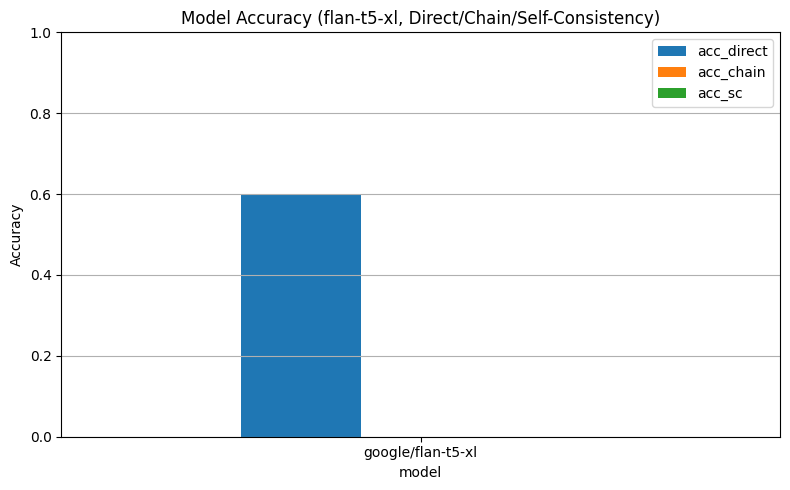

In [72]:
# === 9-6: 실험 실행 및 결과 시각화 ===
if __name__ == "__main__":
    data = [
        {"question": "What is 7 + 5?",                    "ground_truth": "12"},
        {"question": "If 3 * 4 = 12, what is 12 / 3?",     "ground_truth": "4"},
        {"question": "9 - 2 = ?",                          "ground_truth": "7"},
        {"question": "15 divided by 5 equals ?",           "ground_truth": "3"},
        {"question": "8 times 6 equals ?",                 "ground_truth": "48"},
    ]
    df = pd.DataFrame(data)

    all_results = pd.DataFrame()

    for model_name in MODEL_NAMES:
        result_df = evaluate(df, model_name)
        all_results = pd.concat([all_results, result_df], ignore_index=True)

    # 결과 확인 (정상 컬럼명 사용)
    print(all_results[[
        "question", "prediction_direct", "prediction_chain", "prediction_sc",
        "ground_truth", "acc_direct", "acc_chain", "acc_sc"
    ]])

    # 평균 정확도 출력
    accuracy_df = all_results.groupby('model')[['acc_direct', 'acc_chain', 'acc_sc']].mean()
    print("\nAverage Accuracy:")
    print(accuracy_df)

    # 시각화
    accuracy_df.plot.bar(
        figsize=(8, 5), ylim=(0, 1),
        title="Model Accuracy (flan-t5-xl, Direct/Chain/Self-Consistency)"
    )
    plt.xticks(rotation=0)
    plt.ylabel("Accuracy")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


---
# Q7. : Retrieval-Augmented Generation (RAG) + PEFT (LoRA) Pipeline

In [1]:
!pip install --upgrade --no-cache-dir datasets bitsandbytes peft transformers torch

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [3]:
!pip install faiss-cpu

In [4]:
# 기존의 PyTorch 제거
!pip uninstall torch torchvision torchaudio -y

# 호환 가능한 최신 PyTorch와 torchvision 재설치 (CUDA 12.1 버전으로 설치 권장)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


Found existing installation: torch 2.8.0
Uninstalling torch-2.8.0:
  Successfully uninstalled torch-2.8.0
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (780.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp312-cp312-linux_x86_64.whl (7.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp312-cp312-linux_x86_64.whl (3.4 MB)
  Using cached https://download.pytorch.org/whl/cu121/nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached https://download.pytorch.org/whl/cu121/nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached https://download.pytorch.org/whl/cu121/nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014

In [5]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())


2.5.1+cu121
0.20.1+cu121
True


In [6]:
# === 7-1: 환경 설정 & 라이브러리 임포트 ===
import os
import faiss
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModel, AutoModelForCausalLM,
    BitsAndBytesConfig, GenerationConfig
)
from peft import LoraConfig, TaskType, get_peft_model

# GPU 설정 (PyTorch 및 Transformers는 GPU 사용 가능)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"현재 사용 중인 장치: {device}")

# Faiss를 CPU로 명시적으로 사용 (필수)
faiss_device = 'cpu'
print(f"Faiss는 {faiss_device.upper()} 환경에서 동작 중입니다.")

현재 사용 중인 장치: cuda
Faiss는 CPU 환경에서 동작 중입니다.


In [7]:
# === 7-2: 문서 코퍼스 로드 및 전처리 ===
# - 'id','text' 컬럼이 있음
from datasets import load_dataset
import pandas as pd

# 캐시 무시하고 항상 새로 다운로드
ds = load_dataset("ag_news", split="train", download_mode="force_redownload")

# DataFrame으로 변환
df_docs = pd.DataFrame({
    "id": list(range(len(ds))),
    "text": ds["text"]
})

# Optional: 상위 10,000개만 사용
df_docs = df_docs.iloc[:10_000].reset_index(drop=True)

print(df_docs.shape)
df_docs.head()



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

(10000, 2)


,id,text
0,0,Wall St. Bears Claw Back Into the Black (Reute...
1,1,Carlyle Looks Toward Commercial Aerospace (Reu...
2,2,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,4,"Oil prices soar to all-time record, posing new..."


In [11]:
import re
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm

# 토크나이저 로드 (retriever용)
tokenizer_retr = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model_retr = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2").to(device)
model_retr.eval()

def preprocess(text):
    # 간단한 전처리: 소문자화, 특수문자 제거, strip
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.strip()

df_docs["clean"] = df_docs["text"].map(preprocess)

# 문서 임베딩 생성
embeddings = []
with torch.no_grad():
    for txt in tqdm(df_docs["clean"], desc="encode docs"):
        # 1. 텍스트 토큰화 및 GPU로 이동
        inputs = tokenizer_retr(txt, return_tensors='pt', padding=True, truncation=True, max_length=512).to(device)

        # 2. 모델을 통과시켜 임베딩 추출
        outputs = model_retr(**inputs)

        # 3. Mean Pooling 수행
        token_embeddings = outputs.last_hidden_state
        attention_mask = inputs['attention_mask']
        mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        embedding = sum_embeddings / sum_mask

        # 4. 정규화 및 CPU로 이동 후 저장
        embedding = torch.nn.functional.normalize(embedding, p=2, dim=1)
        embeddings.append(embedding.cpu().numpy())

emb_matrix = np.vstack(embeddings).astype("float32")
print("Document embeddings shape:", emb_matrix.shape)

encode docs: 100%|██████████| 10000/10000 [00:59<00:00, 166.90it/s]

Document embeddings shape: (10000, 384)


In [33]:
# === 7-3: FAISS 인덱스 구성 ===
d = emb_matrix.shape[1]
index = faiss.IndexFlatIP(d)   # inner-product (cosine 유사도)
index = faiss.IndexIDMap(index)
# --- 문제 시작 ---

# 문서의 ID와 해당 문서의 임베딩 벡터를 인덱스에 추가합니다.
index.add_with_ids(emb_matrix, df_docs["id"].values)

print(f"FAISS index created with {index.ntotal} documents.")
# --- 문제 끝 ---

FAISS index created with 10000 documents.


In [34]:
# === 7-4: Retriever 함수 ===
def retrieve(query:str, top_k:int=5):
    q_clean = preprocess(query)
    inputs = tokenizer_retr(q_clean, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        q_emb_raw = model_retr(**inputs).last_hidden_state[:,0]
        q_emb_normalized = torch.nn.functional.normalize(q_emb_raw, p=2, dim=1)
        q_emb = q_emb_normalized.cpu().numpy().astype("float32")

    # --- 문제 시작 ---
    # FAISS search
    scores, ids = index.search(q_emb, top_k)

    retrieved_ids = ids[0]
    retrieved_scores = scores[0]

    retrieved_docs = df_docs.iloc[retrieved_ids].copy()
    retrieved_docs["score"] = retrieved_scores

    return retrieved_docs
    # --- 문제 끝 ---

In [14]:
!pip install bitsandbytes

In [35]:
# === 7-5: RAG 래퍼 정의 ===
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig, GenerationConfig
import torch

MODEL_NAME = "microsoft/Phi-3-mini-4k-instruct"

# 4-bit quantization 설정 (작은 GPU 메모리에 최적화)
quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
    bnb_4bit_use_double_quant=True,
)

# 모델 로드
# --- 문제 시작 ---
tokenizer_gen = AutoTokenizer.from_pretrained(MODEL_NAME)
model_gen = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=quant_config,
    device_map="auto",
    trust_remote_code=True,
)
# --- 문제 끝 ---

# GenerationConfig 설정
gen_config = GenerationConfig(
    max_new_tokens=256,
    temperature=0.7,
    top_p=0.9,
    do_sample=True,
)

# Retriever 함수와 연동한 최종 RAG 함수
def rag_generate(question:str):
    docs = retrieve(question, top_k=3)
    # --- 문제 시작 ---
    context_str = "\n".join(docs['clean'].tolist())

    prompt = f"### Context:\n{context_str}\n\n### Question:\n{question}\n\n### Answer:\n"

    inputs = tokenizer_gen(prompt, return_tensors="pt").to(model_gen.device)

    out = model_gen.generate(**inputs, generation_config=gen_config)
    # --- 문제 끝 ---
    return tokenizer_gen.decode(out[0], skip_special_tokens=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [36]:
for name, module in model_gen.named_modules():
    print(name)



model
model.embed_tokens
model.embed_dropout
model.layers
model.layers.0
model.layers.0.self_attn
model.layers.0.self_attn.o_proj
model.layers.0.self_attn.qkv_proj
model.layers.0.self_attn.rotary_emb
model.layers.0.mlp
model.layers.0.mlp.gate_up_proj
model.layers.0.mlp.down_proj
model.layers.0.mlp.activation_fn
model.layers.0.input_layernorm
model.layers.0.resid_attn_dropout
model.layers.0.resid_mlp_dropout
model.layers.0.post_attention_layernorm
model.layers.1
model.layers.1.self_attn
model.layers.1.self_attn.o_proj
model.layers.1.self_attn.qkv_proj
model.layers.1.self_attn.rotary_emb
model.layers.1.mlp
model.layers.1.mlp.gate_up_proj
model.layers.1.mlp.down_proj
model.layers.1.mlp.activation_fn
model.layers.1.input_layernorm
model.layers.1.resid_attn_dropout
model.layers.1.resid_mlp_dropout
model.layers.1.post_attention_layernorm
model.layers.2
model.layers.2.self_attn
model.layers.2.self_attn.o_proj
model.layers.2.self_attn.qkv_proj
model.layers.2.self_attn.rotary_emb
model.layers.

In [37]:
# === 7-6: PEFT (LoRA) 적용 ===
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=[
        "self_attn.qkv_proj",
        "self_attn.o_proj",
        "mlp.gate_up_proj",
        "mlp.down_proj"
    ]
)

# --- 문제 시작 ---
peft_model = get_peft_model(model_gen, peft_config)

peft_model.print_trainable_parameters()
# --- 문제 끝 ---

trainable params: 25,165,824 || all params: 3,846,245,376 || trainable%: 0.6543


In [38]:
# === 7-7: PEFT 미세조정용 데이터셋 준비 ===
# 이미 불러온 df_docs 활용
df_qa = pd.DataFrame({
    "question": df_docs["text"].apply(lambda x: "What is this news about?"),
    "answer": df_docs["text"]
}).iloc[:1000]  # 1,000개만 사용 (조정 가능)

print(df_qa.head())

class QADataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len=256):
        self.df = df
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        q = self.df.question.iloc[idx]
        a = self.df.answer.iloc[idx]
        prompt = f"Q: {q}\nA:"
        enc = self.tokenizer(
            prompt,
            truncation=True,
            max_length=self.max_len,
            padding="max_length",
            return_tensors="pt"
        )
        with self.tokenizer.as_target_tokenizer():
            tgt = self.tokenizer(
                a,
                truncation=True,
                max_length=self.max_len,
                padding="max_length",
                return_tensors="pt"
            )
        return {
            "input_ids": enc.input_ids.squeeze(),
            "attention_mask": enc.attention_mask.squeeze(),
            "labels": tgt.input_ids.squeeze()
        }

# 데이터셋 및 DataLoader 준비
# --- 문제 시작 ---
train_ds = QADataset(df_qa, tokenizer_gen)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=8, shuffle=True)
# --- 문제 끝 ---

print("데이터 로딩 완료. 예시 배치:")
batch = next(iter(train_loader))
print(batch["input_ids"].shape)
print(batch["labels"].shape)


                   question                                             answer
0  What is this news about?  Wall St. Bears Claw Back Into the Black (Reute...
1  What is this news about?  Carlyle Looks Toward Commercial Aerospace (Reu...
2  What is this news about?  Oil and Economy Cloud Stocks' Outlook (Reuters...
3  What is this news about?  Iraq Halts Oil Exports from Main Southern Pipe...
4  What is this news about?  Oil prices soar to all-time record, posing new...
데이터 로딩 완료. 예시 배치:
torch.Size([8, 256])
torch.Size([8, 256])


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [28]:
!pip install -U transformers accelerate

In [41]:
# === 7-8: PEFT 학습 루프 ===
optim = torch.optim.AdamW(peft_model.parameters(), lr=2e-4)
peft_model.train()

for epoch in range(3):
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
        # --- 문제 시작 ---
        batch = {k: v.to(peft_model.device) for k, v in batch.items()}

        optim.zero_grad()

        outputs = peft_model(**batch)
        loss = outputs.loss

        loss.backward()

        optim.step()
        # --- 문제 끝 ---
    print(f"Epoch {epoch} final loss: {loss.item():.4f}")

Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Epoch 0:   0%|          | 0/125 [00:00<?, ?it/s]


AttributeError: 'DynamicCache' object has no attribute 'get_usable_length'

In [40]:
# === 7-9: 평가 및 비교 ===
peft_model.eval()

# df_docs에서 평가 데이터셋 준비 (학습 데이터와 겹치지 않게 설정)
df_test = df_docs.iloc[1000:1200].reset_index(drop=True)  # 200개 샘플 평가

results = []
for _, row in tqdm(df_test.iterrows(), total=len(df_test), desc="Evaluating"):
    question = "What is this news about?"
    ground_truth = row.text.strip()
    prediction = rag_generate(question).split("### Answer:")[-1].strip()

    results.append({
        "question": question,
        "ground_truth": ground_truth,
        "prediction": prediction,
        "correct": prediction == ground_truth
    })

# 간단한 정확도 측정 (완전 일치 여부)
accuracy = np.mean([r["correct"] for r in results])
print(f"Accuracy (Exact Match): {accuracy:.2%}")

# 결과 예시 확인
for idx in range(3):
    print("\nExample", idx+1)
    print("Q:", results[idx]["question"])
    print("Ground Truth:", results[idx]["ground_truth"])
    print("Prediction:", results[idx]["prediction"])

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]


AttributeError: 'DynamicCache' object has no attribute 'seen_tokens'

---
# Q8 ~ 9 : Transformer from scratch

8-1 Transformer from scratch
-- Transformer 모델을 직접 python으로 구현해봅니다. Transformer 모델의 핵심 구조인 Encoder 및 decoder를 이루는 multi-head attention layer를 완성하고, dummy data로 이루어진 random 시계열이 에러 없이 학습 loop가 돌아가는지 확인합니다.
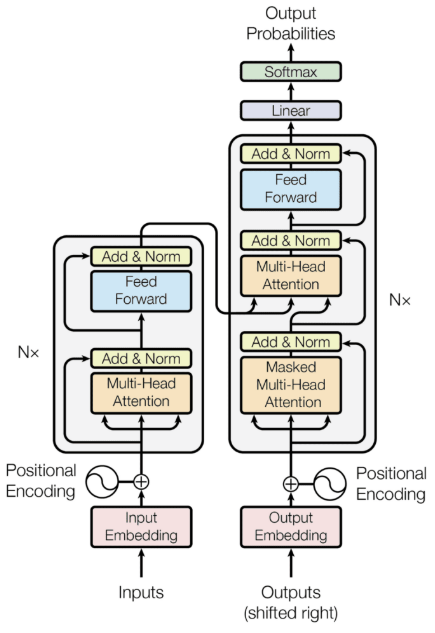

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        # TODO: d_model이 num_heads로 나누어지기 위한 assert 조건
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        TODO: Mask = None일 때와 None이 아닐 때를 구분해야 함
        적절한 attn_probs를 만들어서, 코드의 마지막 두 줄을 변경하지 않아야 함
        """
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        attn_probs = F.softmax(attn_scores, dim=-1)

        output = torch.matmul(attn_probs, V)
        return output

    def split_heads(self, x):
        """
        TODO: x가 multi-heads 구조에 compatible하도록 구조 변경
        코드는 return 코드 포함 2줄을 넘기질 말 것.
        """
        batch_size, seq_length, _ = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)

    def combine_heads(self, x):
        """
        TODO: x를 multi-heads 구조에서 원래 구조로 변경, 아래 return을 얻을 수 있도록 여기에 1줄만 추가해야 함.
        """
        batch_size, _, seq_length, _ = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)

    def forward(self, Q, K, V, mask=None):
        """
        TODO: 여기에 Q, K, V를 구하는 코드 3줄 작성
        """
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))

        # TODO: attn_output을 구하는 1줄 코드 작성
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)

        # TODO: output을 구하는 1줄 코드 작성
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [44]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_hidden):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_hidden)
        self.fc2 = nn.Linear(d_hidden, d_model)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [46]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()

        """
        TODO: self.posenc 틀 생성
        """
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))

        """
        TODO: 정의한 self.posenc에 div_term을 apply
        """
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('posenc', pe.unsqueeze(0))

    def forward(self, x):
        return x + self.posenc[:, :x.size(1)]

In [47]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x

In [48]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout1(attn_output))

        cross_attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout2(cross_attn_output))

        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout3(ff_output))
        return x

In [49]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_pad_mask = (tgt != 0).unsqueeze(1).unsqueeze(2)

        seq_length = tgt.size(1)
        tgt_causal_mask = torch.tril(torch.ones(seq_length, seq_length, device=tgt.device)).bool()

        tgt_mask = tgt_pad_mask & tgt_causal_mask

        return src_mask, tgt_mask

    def forward(self, src, tgt):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

아래 주어진 src_data 및 tgt_data는 random dummy data입니다. 이 data로 학습을 진행할 경우 train loss는 줄어들지 않을 것입니다. 하지만 error 없이 이 코드까지 돌아갈 수 있도록 윗 부분의 TODO를 완성해야 합니다.

In [50]:
src_vocab_size = 5000
tgt_vocab_size = 5000
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = 100
dropout = 0.1

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)

# Generate random sample data
src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

In [51]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

transformer.train()

for epoch in range(10):
    optimizer.zero_grad()
    output = transformer(src_data, tgt_data[:, :-1])
    loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
    loss.backward()
    optimizer.step()
    print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

Epoch: 1, Loss: 8.688275337219238
Epoch: 2, Loss: 8.552377700805664
Epoch: 3, Loss: 8.481821060180664
Epoch: 4, Loss: 8.426499366760254
Epoch: 5, Loss: 8.364399909973145
Epoch: 6, Loss: 8.296977043151855
Epoch: 7, Loss: 8.220098495483398
Epoch: 8, Loss: 8.137982368469238
Epoch: 9, Loss: 8.05875301361084
Epoch: 10, Loss: 7.985239505767822


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


8-2 다음 pkl 데이터를 적절한 Tokenization 및 전처리 알고리즘을 통해 위 dummy data의 형태와 같이 만들어야 합니다:

english-german-both.pkl


아래 주어진 PrepareDataset class를 이용하세요.

In [86]:
from pickle import load
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

class PrepareDataset:
    def __init__(self, **kwargs):
        super(PrepareDataset, self).__init__(**kwargs)
        self.n_sentences = 10000
        self.train_split = 0.9

    def create_tokenizer(self, dataset):
        tokenizer = Tokenizer(oov_token="<unk>")
        tokenizer.fit_on_texts(dataset)
        return tokenizer

    def find_seq_length(self, dataset):
        return max(len(seq.split()) for seq in dataset)

    def find_vocab_size(self, tokenizer, dataset):
        return len(tokenizer.word_index) + 1

    def __call__(self, filename, **kwargs):
        clean_dataset = load(open(filename, 'rb'))
        dataset = clean_dataset[:self.n_sentences, :]

        for i in range(dataset[:, 0].size):
            dataset[i, 0] = "<START> " + dataset[i, 0] + " <EOS>"
            dataset[i, 1] = "<START> " + dataset[i, 1] + " <EOS>"

        train = dataset[:int(self.n_sentences * self.train_split)]

        enc_tokenizer = self.create_tokenizer(train[:, 0])
        enc_seq_length = self.find_seq_length(train[:, 0])
        enc_vocab_size = self.find_vocab_size(enc_tokenizer, train[:, 0])
        trainX = enc_tokenizer.texts_to_sequences(train[:, 0])
        trainX = pad_sequences(trainX, maxlen=enc_seq_length, padding='post')

        dec_tokenizer = self.create_tokenizer(train[:, 1])
        dec_seq_length = self.find_seq_length(train[:, 1])
        dec_vocab_size = self.find_vocab_size(dec_tokenizer, train[:, 1])
        trainY = dec_tokenizer.texts_to_sequences(train[:, 1])
        trainY = pad_sequences(trainY, maxlen=dec_seq_length, padding='post')

        return (trainX, trainY, train,
                enc_tokenizer, dec_tokenizer,
                enc_seq_length, dec_seq_length,
                enc_vocab_size, dec_vocab_size)

9-1 위 8-2의 데이터셋을 활용하여 8-1에서 만든 Transformer 모델을 이용해 machine translator가 학습이 이루어지는지 검증하세요.
epoch별 train loss를 plot하여, 실제로 train loss가 떨어지고 있다는 것을 검증하면 됩니다.

Epoch 1/10 - Train Loss: 5.5027
Epoch 2/10 - Train Loss: 5.2991
Epoch 3/10 - Train Loss: 5.2673
Epoch 4/10 - Train Loss: 5.2547
Epoch 5/10 - Train Loss: 5.2506
Epoch 6/10 - Train Loss: 5.2438
Epoch 7/10 - Train Loss: 5.2337
Epoch 8/10 - Train Loss: 5.1504
Epoch 9/10 - Train Loss: 4.9923
Epoch 10/10 - Train Loss: 4.8849


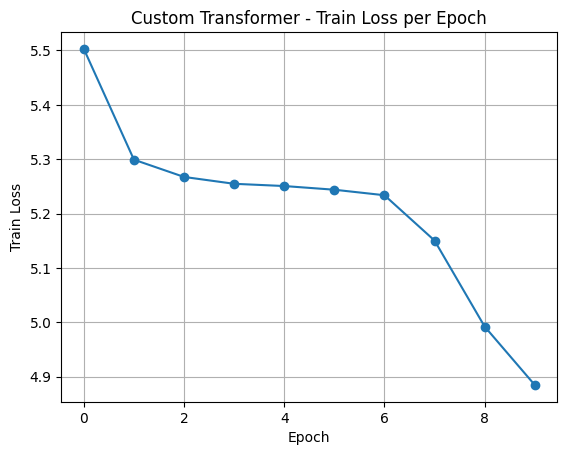

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import math
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
# 학습 파라미터
epochs = 10
batch_size = 64
learning_rate = 0.001

prepare = PrepareDataset()
trainX, trainY, train_raw, enc_tokenizer, dec_tokenizer, enc_seq_length, dec_seq_length, enc_vocab_size, dec_vocab_size = prepare("/content/drive/MyDrive/english-german-both.pkl")

# 텐서로 변환
trainX = torch.tensor(trainX, dtype=torch.long)
trainY = torch.tensor(trainY, dtype=torch.long)
dataset = TensorDataset(trainX, trainY)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# 모델 하이퍼파라미터 정의
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 2048
max_seq_length = max(enc_seq_length, dec_seq_length)
dropout = 0.1

# 모델 초기화
model = Transformer(enc_vocab_size, dec_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []

train_losses = []

# 학습 루프
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for src_batch, tgt_batch in loader:
        optimizer.zero_grad()

        # Shift target for teacher forcing
        output = model(src_batch, tgt_batch[:, :-1])
        output = output.reshape(-1, dec_vocab_size)
        target = tgt_batch[:, 1:].reshape(-1)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f}")

# Loss 시각화
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("Custom Transformer - Train Loss per Epoch")
plt.grid()
plt.show()

9-2 위 8-2의 데이터셋을 활용하여 pytorch의 transformer 모델을 import하여, machine translator가 학습이 이루어지는지 검증하세요.

Epoch 1/10 - Train Loss: 5.5147
Epoch 2/10 - Train Loss: 5.2905
Epoch 3/10 - Train Loss: 5.2603
Epoch 4/10 - Train Loss: 5.2515
Epoch 5/10 - Train Loss: 5.2439
Epoch 6/10 - Train Loss: 5.2409
Epoch 7/10 - Train Loss: 5.2368
Epoch 8/10 - Train Loss: 5.2344
Epoch 9/10 - Train Loss: 5.2326
Epoch 10/10 - Train Loss: 5.2305


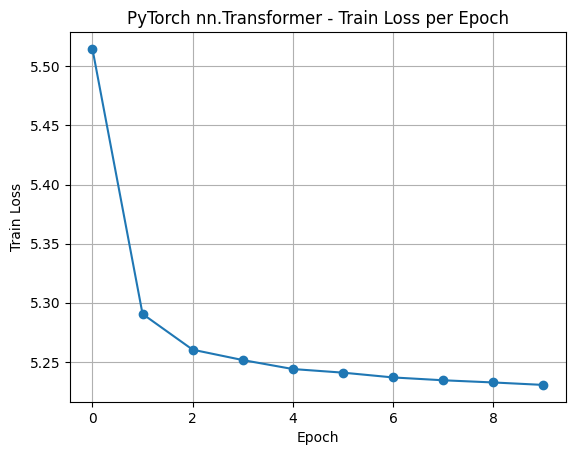

In [91]:
from torch.nn import Transformer

class SimpleTransformerModel(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, d_model=512, nhead=8, num_layers=6):
        super().__init__()


        self.src_embedding = nn.Embedding(src_vocab, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab, d_model)

        self.transformer = Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers
        )

        self.fc_out = nn.Linear(d_model, tgt_vocab)


    def forward(self, src, tgt):

        src_embedded = self.src_embedding(src).permute(1, 0, 2)
        tgt_embedded = self.tgt_embedding(tgt).permute(1, 0, 2)


        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(1))

        output = self.transformer(src_embedded, tgt_embedded, tgt_mask=tgt_mask)


        output = output.permute(1, 0, 2)

        return self.fc_out(output)


# 모델 학습
model = SimpleTransformerModel(src_vocab_size, tgt_vocab_size)
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for src_batch, tgt_batch in loader:
        optimizer.zero_grad()
        output = model(src_batch, tgt_batch[:, :-1])
        output = output.reshape(-1, tgt_vocab_size)
        target = tgt_batch[:, 1:].reshape(-1)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_loss:.4f}")

# 시각화
plt.plot(train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Train Loss")
plt.title("PyTorch nn.Transformer - Train Loss per Epoch")
plt.grid()
plt.show()

Q10. 기계 구조물의 이상 가동을 탐지하기 위해, 설비 별로 온도 센서를 부착하여 일정 시간마다 센서 값을 받아서 분석하고자 합니다. 각 엑셀 파일은 설비의 이름을 나타냅니다. 엑셀 파일을 열어 보면, 다음과 같은 데이터의 특징을 발견할 수 있습니다:
===
- 설비의 전원 ON/OFF 상태에 따라 센서 값이 다릅니다 (전원이 OFF 상태인 경우는 ON인 경우보다 주로 낮은 센서 값을 보여줍니다)
- 센서 값이 간혹 1~2개씩 튀는 경우가 있습니다.
- 센서 값을 읽는 데 실패하여 NaN이 저장되는 경우가 있습니다.
- 설비를 점검하는 기간이 존재합니다. 이 기간 동안에는 위의 경우보다 긴 시간동안 센서 값이 위아래로 요동치는 경향이 있습니다.

설비의 온도 변화 패턴 학습을 위한 데이터 수집에 앞서, 위 상황들에 대한 이상치 처리 (outlier rejection)를 하고자 합니다. 아래와 같이 outlier를 정의합니다:
- 설비의 전원이 OFF인 경우는 outlier data로 처리함
- 센서 값이 비이상적으로 튀는 경우 outlier data로 처리함
- 설비 점검 기간 중 튀는 모든 구간의 데이터를 outlier로 처리함
- 센서 값이 NaN으로 저장되는 경우는 센서 값이 999로 표기되어 있고, 이는 outlier로 처리됩니다.
다만, 전체 데이터를 모두 보고 outlier detection을 하지는 않습니다. 데이터가 실시간으로 12개씩 새로 들어온다고 가정하고, 기존 데이터를 바탕으로 새로 들어오는 데이터의 outlier 여부를 판단하는 모델이 필요합니다.

각 설비별 로그 파일에서는 outlier로 분류된 데이터를 확인할 수 있습니다.
지금까지 배운 시계열 분석 model 중 자신 있는 model을 활용하여, 실시간 outlier detection 알고리즘을 완성해 보세요.

- outlier_initialization 함수에서는 설비별 첫 5000개 데이터 (1~5000행)에 대한 초기 outlier 분류 작업을 수행하는 알고리즘을 만들어 주세요

- outlier_classification 함수에서는 초기 분류 작업 이후, 실시간으로 데이터가 12개씩 들어오게 되는데, 이 때, 가장 최근 8064개 데이터를 바탕으로 outlier 여부를 결정해 주세요.

- 실시간 데이터가 8064개 이하로 쌓인 경우에는, 모아진 데이터를 바탕으로 outlier 여부를 결정해 주세요. 즉, fixed-window를 사용하지 않아야 합니다.

In [1]:
import random
import numpy as np
import pandas as pd
def load_and_preprocess_data(file_path):

    try:
      df = pd.read_csv(file_path,  parse_dates=['TIMESTAMP_DT'])
    except:
      df = pd.read_csv(file_path, encoding='cp949', parse_dates=['TIMESTAMP_DT'])
    df.set_index('TIMESTAMP_DT', inplace=True)

    df.index = df.index.round('5min')
    df = df[~df.index.duplicated(keep='first')]

    df = df.asfreq('5min')

    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df_resampled = df.resample('5min').mean(numeric_only=True)

    df_resampled['CH_VALUE'] = df_resampled['CH_VALUE'].fillna(999)

    other_cols = df_resampled.columns.difference(['CH_VALUE'])
    df_resampled[other_cols] = df_resampled[other_cols].interpolate(method='linear')

    t0 = df_resampled.index[0]
    df_resampled['time_days'] = (df_resampled.index - t0).total_seconds() / 86400

    df_resampled = df_resampled.reset_index()

    return df_resampled

In [3]:
import os, math, pandas as pd, numpy as np
import matplotlib.pyplot as plt

def outlier_initialization(df_train, TRAIN_WINDOW):
    df_train_final = df_train.copy()
    values = df_train_final['CH_VALUE'].values
    q1 = np.nanpercentile(values, 25)
    q3 = np.nanpercentile(values, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    df_train_final['OUTLIER'] = False
    df_train_final.loc[df_train_final['CH_VALUE'] == 999, 'OUTLIER'] = True
    df_train_final.loc[(values < lower) | (values > upper), 'OUTLIER'] = True

    detector = {'lower': lower, 'upper': upper}
    return df_train_final, detector


def outlier_classification(detector, df_all, TRAIN_WINDOW, batch_size):
    df_batch = df_all.tail(batch_size).copy()
    window = df_all.tail(min(len(df_all), TRAIN_WINDOW))
    values = window['CH_VALUE'].values
    q1 = np.nanpercentile(values, 25)
    q3 = np.nanpercentile(values, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr

    df_batch['OUTLIER'] = False
    df_batch.loc[df_batch['CH_VALUE'] == 999, 'OUTLIER'] = True
    df_batch.loc[(df_batch['CH_VALUE'] < lower) | (df_batch['CH_VALUE'] > upper), 'OUTLIER'] = True

    detector['lower'] = lower
    detector['upper'] = upper
    return df_batch

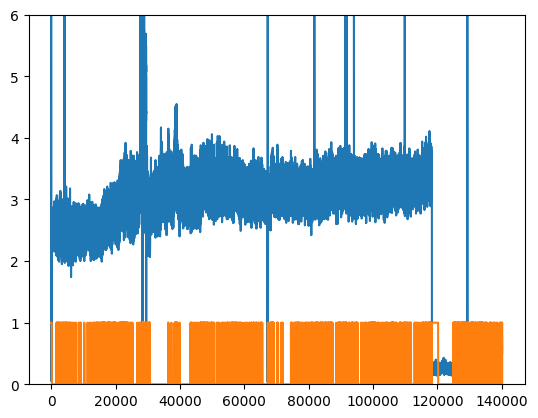

In [5]:
batch_size = 288
TRAIN_TERM = 28


w_size = 288
FUTURE_IDX = 56 * w_size
STAT_IDX = 7 * w_size
TRAIN_WINDOW = TRAIN_TERM * w_size

FILE_PATH = '/content/drive/MyDrive/device1.csv'
"""
해당 파일명을 바꾸어도, 동일한 알고리즘, 동일한 hyperparameter 세팅으로 outlier detection이 이루어져야 함.
파일은 3개 존재함
"""
# data preprocessing
df = load_and_preprocess_data(FILE_PATH)

# Train data
IDX_START = 5000
df_train = df.loc[:IDX_START-1].copy()
df_test = df.loc[IDX_START:].copy()

# Outlier Detection
df_train_, detector_ = outlier_initialization(df_train.iloc[::-1].reset_index(drop=True), TRAIN_WINDOW)
df_train, detector = outlier_initialization(df_train.copy(), TRAIN_WINDOW)
df_train_ = df_train_.iloc[::-1].reset_index(drop = True)
df_train_forgmm = df_train.copy()
df_train_forgmm["OUTLIER"] = df_train["OUTLIER"] * df_train_["OUTLIER"]


# 결과 저장 dataframe
results = list()
df_all = df_train_forgmm.copy()


for start in range(IDX_START, len(df) - 56 * 288, batch_size):
    # 매 스텝당 좌표 정의
    p0 = start + batch_size - 1
    pt, ps, pe = p0 - TRAIN_WINDOW + 1, p0 - STAT_IDX + 1, p0 + FUTURE_IDX
    # start    : 배치 처음 인덱스
    # p0       : 배치 마지막 인덱스
    # pt Train : 시작점
    # ps       : 통계 산출 시작점
    # pe       : 예측 종료점

    # ---------------- #
    #     배치 데이터     #
    # ---------------- #
    # 1. 배치 데이터 업데이트
    df_batch = df.loc[start:p0]

    # 2. 총 관측 데이터
    df_all = pd.concat([df_all, df_batch])

    # 3. 배치 단위 이상치 분류
    df_batch = outlier_classification(detector, df_all, TRAIN_WINDOW, batch_size)


    df_all.loc[df_batch.index, "OUTLIER"] = df_batch["OUTLIER"]

# Save result
df_all.to_csv(f"df_all.csv", index=True)

plt.plot(df_all["CH_VALUE"])
plt.plot(df_all["OUTLIER"])
plt.ylim(0, 6)
plt.show()

df_all.csv에 저장된 분류 알고리즘 결과가, 실제 결과인 device_n_answer에 저장된 outlier 결과와 95% 이상 일치해야 합니다.

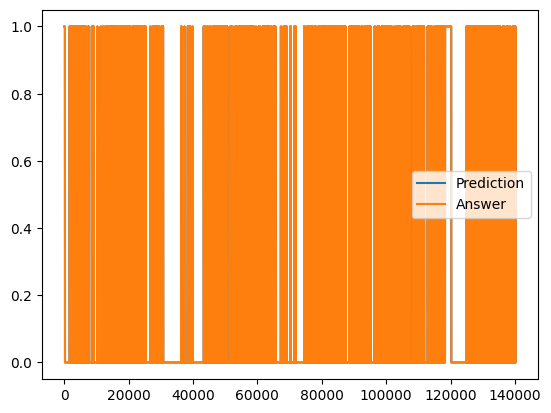

Accuracy: 100.00% (140072 / 140072)


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE_PATH = '/content/df_all.csv'
# 정답 파일 (device1)
answer_df = pd.read_csv(FILE_PATH, parse_dates=['TIMESTAMP_DT'])


# 병합: 공통 TIMESTAMP_DT 기준
merged = pd.merge(
    df_all[['TIMESTAMP_DT', 'OUTLIER']],
    answer_df[['TIMESTAMP_DT', 'OUTLIER']],
    on='TIMESTAMP_DT',
    how='inner',
    suffixes=('_pred', '_true')
)

# 비교: 인덱스 무시
count_same = np.sum(merged['OUTLIER_pred'].values == merged['OUTLIER_true'].values)
count_total = len(merged)
accuracy = count_same / count_total * 100

# 시각화
plt.plot(merged['OUTLIER_pred'].values, label='Prediction')
plt.plot(merged['OUTLIER_true'].values, label='Answer')
plt.legend()
plt.show()

print(f"Accuracy: {accuracy:.2f}% ({count_same} / {count_total})")


[주관식 과제 수행 시 유의사항]

※ 주관식 과제의 채점 기준은 다음과 같습니다

결과 출력값이 주어진 것과 동일하게 표기되어 있는가 (일부 변동성을 띠는 숫자는 제외)
문제 내에서 요구하는 요구사항들을 모두 이행하였는가
따라서 문제 내에서 요구하는 작은 요소라도 반드시 놓치지 마시고, 모두 고려하여 코드를 작성해주시기 바랍니다.

실제 현업에서의 데이터 분석가는 세심함과 정확성이 요구되는 작업입니다.

특히, 조건과 컬럼 하나하나를 명확하게 설정하고 관리하는 것이 중요합니다.

이러한 부분을 주관식 문제를 통해 반영하고자 하였습니다.

과제 평가 시 해당 내용들을 기준으로 평가하므로, 이 점을 유념하여 과제를 수행해주시기 바랍니다.

만약 위 기준에 부합하지 않는 항목이 있을 경우, 해당 문제는 오답으로 0점 처리되오니 참고하시기 바랍니다.